# Tracking changes in SARS-CoV-2 transmission with a novel outpatient sentinel surveillance system in Chicago, USA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
import scipy
import gc

from helpers import *

In [2]:
import epyestim
import epyestim.covid19 as covid19

In [3]:
today_str = dt.datetime.today().strftime('%y%m%d')

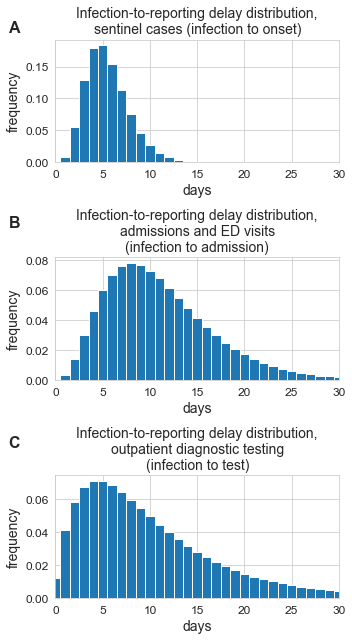

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,9))
alpha = 1
# Panel A ###################################################
my_continuous_distrb = scipy.stats.gamma(a=5.807, scale=0.948)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)
sc_distrb = my_discrete_distrb
axes[0].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[0].set_xlim([0,30])
axes[0].set_title('Infection-to-reporting delay distribution,\nsentinel cases (infection to onset)', fontsize=14)
axes[0].set_xlabel('days', fontsize=14)

# Panel B ###################################################
alpha1 = 5.807
theta1 = 0.948
#print(alpha1*theta1)
alpha2 = 1.104 #5.074 
theta2 = 5.074 #1.104
#print(alpha2*theta2)
k_sum = (alpha1*theta1 + alpha2*theta2)**2/((alpha1*theta1**2) + (alpha2*theta2**2))
theta_sum = (alpha1*theta1 + alpha2*theta2)/k_sum

k_sum = (alpha1*theta1 + alpha2*theta2)**2/((alpha1*theta1**2) + (alpha2*theta2**2))
theta_sum = (alpha1*theta1 + alpha2*theta2)/k_sum

#print(k_sum, theta_sum)
#print(k_sum*theta_sum)

my_continuous_distrb = scipy.stats.gamma(a=k_sum, scale=theta_sum)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)
#my_discrete_distrb = covid19.generate_standard_infection_to_reporting_distribution()
cli_distrb = my_discrete_distrb
axes[1].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[1].set_xlim([0,30])
axes[1].set_title('Infection-to-reporting delay distribution,\nadmissions and ED visits\n(infection to admission)', fontsize=14)
axes[1].set_xlabel('days', fontsize=14)

# Panel C ###################################################
case_distrb = covid19.generate_standard_infection_to_reporting_distribution()
my_discrete_distrb = case_distrb
axes[2].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[2].set_xlim([0,30])
axes[2].set_title('Infection-to-reporting delay distribution,\noutpatient diagnostic testing\n(infection to test)', fontsize=14)
axes[2].set_xlabel('days', fontsize=14)

#print(k_sum, theta_sum)
#print(k_sum*theta_sum)
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylabel('frequency', fontsize=14)

fig.text(y=0.95, x=0.05, s='A', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.65, x=0.05, s='B', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.31, x=0.05, s='C', va='center', ha='center', fontsize=16, weight='bold')
fig.tight_layout()
fig.savefig('supp_fig_1_'+ today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_1_'+ today_str + '.pdf', bbox_inches='tight')

In [5]:
np.sum(case_distrb*np.arange(len(case_distrb)))

10.335982624278122

In [6]:
print(med_and_iqr(sc_distrb))
print(med_and_iqr(cli_distrb))
print(med_and_iqr(case_distrb))

(5, (4, 7))
(10, (7, 14))
(8, (4, 14))


# Pulling and archiving data

In [ ]:
cli = pd.read_csv('~/Box/covid_IDPH/Corona virus reports/CLI_admissions.csv') #Good! This is actual CLI
cli['date'] = pd.to_datetime(cli['date'], utc=True)
cli_series = cli[cli['region'] == 'Chicago'].groupby('date').sum()['inpatient']

r_cli = covid19.r_covid(cli_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
#r_cli_partial = covid19.r_covid(cli_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=False)

In [ ]:
#Archiving CLI (Aug 25, 2021)
cli_series.to_csv('cli_hospitalizations_chicago_210825.csv', index=False)

In [ ]:
cli_ed = pd.read_csv('https://data.cityofchicago.org/resource/qwib-edaw.csv')
cli_ed['date'] = pd.to_datetime(cli_ed['date'], utc=True)
cli_ed = cli_ed.sort_values('date').reset_index(drop=True)

covid_ed_series = cli_ed.set_index('date')['total_covid_daily']
covid_ed_series = covid_ed_series.dropna()
r_covid_ed = covid19.r_covid(covid_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

cli_ed_series = cli_ed.set_index('date')['total_cli_daily']
cli_ed_series = cli_ed_series.dropna()
r_cli_ed = covid19.r_covid(cli_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

In [8]:
cli_cdph = pd.read_csv('https://data.cityofchicago.org/resource/naz8-j4nc.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['lab_report_date'], utc=True)
cli_cdph = cli_cdph.sort_values('date').reset_index(drop=True).dropna(subset=['date'])

cli_cdph_series = cli_cdph.set_index('date')['hospitalizations_total']

cli_cdph_series = cli_cdph_series.dropna()

r_cli_cdph = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
r_cli_cdph_partial = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=False)

In [19]:
#Archiving data (Sept 23, 2021)
cli_ed.to_csv('ed_visits_chicago_210923.csv', index=False)
cli_cdph.to_csv('hospitalizations_chicago_210923.csv', index=False)

# Retrieving archived data

In [127]:
#Retrieving archived data
# CLI hospitalizations
cli = pd.read_csv('./data/CLI_admissions_210825.csv') #Good! This is actual CLI
cli['date'] = pd.to_datetime(cli['date'], utc=True)
cli_series = cli[cli['region'] == 'Chicago'].groupby('date').sum()['inpatient']

np.random.seed(2022)
r_cli = covid19.r_covid(cli_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

# ED visits (CLI & covid-confirmed)
cli_ed = pd.read_csv('./data/ed_visits_chicago_210923.csv')
cli_ed['date'] = pd.to_datetime(cli_ed['date'], utc=True)

covid_ed_series = cli_ed.set_index('date')['total_covid_daily']
covid_ed_series = covid_ed_series.dropna()
np.random.seed(2022)
r_covid_ed = covid19.r_covid(covid_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

cli_ed_series = cli_ed.set_index('date')['total_cli_daily']
cli_ed_series = cli_ed_series.dropna()
np.random.seed(2022)
r_cli_ed = covid19.r_covid(cli_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

cli_cdph_series = cli_cdph.set_index('date')['hospitalizations_total']
cli_cdph_series = cli_cdph_series.dropna()

np.random.seed(2022)
r_cli_cdph = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
#r_cli_cdph_partial = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=False)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

# cases
case_series = cli_cdph.set_index('date')['cases_total']
case_series = case_series.dropna()
np.random.seed(2022)
r_case = covid19.r_covid(case_series, delay_distribution=case_distrb, r_window_size=14, auto_cutoff=True)

In [128]:
curative = pd.read_csv('./data/2021.07.06 Master Set Data Only_Deidentified.csv', encoding= 'unicode_escape')
curative['patient_symptom_date'] = pd.to_datetime(curative['patient_symptom_date'], errors='coerce')
curative['collection_time'] = pd.to_datetime(curative['collection_time'], errors='coerce')
curative['days'] = (pd.to_datetime(curative['collection_time'], utc=True) - pd.to_datetime(curative['patient_symptom_date'], utc=True)).dt.days

C:\Users\richa\anaconda3\envs\covid_env\lib\site-packages\IPython\core\interactiveshell.py:3134: DtypeWarning: Columns (0,4,10,11,13,15,16,18,19,20,21,22,23,24,25,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [129]:
# tests from curative in time frame
len(curative[(curative['collection_time'] >= pd.to_datetime('09-27-2020')) & 
         (curative['collection_time'] <= pd.to_datetime('6-13-2021'))])

274343

In [130]:
idph =  pd.read_csv('./data/210706_SS_epic.csv', encoding= 'unicode_escape')
idph['test_date'] = pd.to_datetime(idph['test_date'])
idph['test_time'] = pd.to_datetime(idph['test_time'])
idph['date_symptoms_start'] = pd.to_datetime(idph['date_symptoms_start'])
idph['days'] = (idph['test_date'] - idph['date_symptoms_start']).dt.days
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
pos_cond = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
chi_cond = (idph['test_site_city'] == 'CHICAGO')

In [131]:
# tests from IDPH in time frame
len(idph[(idph['test_date'] >= pd.to_datetime('09-27-2020')) & (idph['test_date'] <= pd.to_datetime('6-13-2021'))])

384559

In [132]:
zips = pd.read_csv('./data/Chicago_ZIP_codes.txt', header=None)[0].values

In [133]:
idph['chicago'] = idph['pat_zip_code'].apply(lambda x: zip_in_zips(x, zips))

In [134]:
curative['chicago'] = curative['patient_city'] == 'Chicago'

In [135]:
curative_time_frame_cond = (curative['collection_time'] >= pd.to_datetime('9-27-20')) & (curative['collection_time'] <= pd.to_datetime('6-13-21'))
curative_ss = (curative['days'] >= 0) & (curative['days'] <= 4)
curative_symptom = curative['patient_is_symptomatic']

idph_time_frame_cond = (idph['test_date'] >= pd.to_datetime('9-27-20')) & (idph['test_date'] <= pd.to_datetime('6-13-21'))
idph_ss = (idph['days'] >= 0) & (idph['days'] <= 4)
idph_symptom = idph['symptomatic_per_cdc'] == 'Yes'
idph_chicago_site = (idph['test_site'] == 'IDPH COMMUNITY TESTING AUBURN GRESHAM') | (idph['test_site'] == 'IDPH AUBURN GRESHAM COMMUNITY TESTING') | (idph['test_site'] == 'IDPH HARWOOD HEIGHTS COMMUNITY TESTING')

idph_count = np.sum(idph_time_frame_cond & idph_ss & idph['chicago'] & idph_chicago_site)
curative_count = np.sum(curative_time_frame_cond & curative_ss & curative['chicago'])

print(idph_count)
print(curative_count)

7478
6474


In [136]:
idph[(idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')]['test_site'].value_counts()

IDPH HARWOOD HEIGHTS COMMUNITY TESTING                        31790
IDPH COMMUNITY TESTING AUBURN GRESHAM                         10323
IDPH AUBURN GRESHAM COMMUNITY TESTING                          9095
IDPH BENNETT DAY MOBILE TESTING                                 195
IDPH MCCORMICK YMCA MOBILE TESTING                               73
IDPH SAN LUCAS CHURCH MOBILE TESTING                             22
IDPH REP RAMIREZ/SEN AQUINO OFFICE MOBILE TESTING                17
IDPH MADISON AND PULASKI COMMUNITY POP UP MOBILE TESTING         12
IDPH METROPOLITAN FAMILY SERVICES MOBILE TESTING                 12
IDPH K.L.E.O. COMMUNITY FAMILY LIFE CENTER MOBILE TESTING         9
IDPH LIFE CENTER CHURCH OF GOD IN CHRIST MOBILE TESTING           8
IDPH METROPOLITAN FAMILY SERVICES - BELMONT MOBILE TESTING        5
IDPH MOBILE TESTING BERNARD HORWICH JCC                           2
Name: test_site, dtype: int64

In [137]:
idph_slice = idph[(idph['test_site'] == 'IDPH COMMUNITY TESTING AUBURN GRESHAM') | 
                  (idph['test_site'] == 'IDPH AUBURN GRESHAM COMMUNITY TESTING')]

print(len(idph_slice[(idph_slice['test_date'] >= pd.to_datetime('09-27-2020')) & 
               (idph_slice['test_date'] <= pd.to_datetime('6-13-2021'))]))

(idph_slice.groupby('test_date').count()['pat_id'].reindex(pd.date_range('5-1-2020', '06-30-2021'), fill_value=0.0) > 0).to_csv('auburn_gresham.csv')

idph_slice = idph[(idph['test_site'] == 'IDPH HARWOOD HEIGHTS COMMUNITY TESTING')]
print(len(idph_slice[(idph_slice['test_date'] >= pd.to_datetime('09-27-2020')) & 
               (idph_slice['test_date'] <= pd.to_datetime('6-13-2021'))]))
(idph_slice.groupby('test_date').count()['pat_id'].reindex(pd.date_range('5-1-2020', '06-30-2021'), fill_value=0.0) > 0).to_csv('harwood_heights.csv')

19325
31204


In [138]:
cap = 40
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[ss_cond & idph['chicago'] & chi_idph & idph_chicago_site & (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    collect_cases = collect_cases.append(combo_short[0:cap])
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

In [139]:
all_cases

,date,positive
153449,2020-09-26,False
153806,2020-09-26,True
153608,2020-09-25,False
152430,2020-09-24,False
152748,2020-09-24,True
...,...,...
384803,2021-06-11,False
426519,2021-06-12,False
426502,2021-06-10,False
426545,2021-06-09,False


In [140]:
collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx
combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()

In [141]:
combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
combo_adjust.index = pd.to_datetime(combo_adjust.index)
#combo_adjust.reindex(onset_idx, fill_value=0.0)

In [142]:
print(len(all_cases))
print(all_cases['positive'].sum())

13952
3607


In [143]:
print('Total specimens (curative): ' + str(len(curative[curative_time_frame_cond]['patient_is_symptomatic'])))
print('Total specimens (curative) with documented symptomatology: ' + str(len(curative[curative_time_frame_cond].dropna(subset=['patient_is_symptomatic']))))
print('Total specimens (IDPH): ' + str(len(idph[idph_time_frame_cond & idph_chicago_site])))
print('Total specimens (IDPH) with documented symptomatology: ' + str(np.sum((idph[idph_time_frame_cond & idph['chicago'] & idph_chicago_site]['symptomatic_per_cdc'] == 'Yes') | (idph[idph_time_frame_cond & idph['chicago'] & idph_chicago_site]['symptomatic_per_cdc'] == 'No'))))

Total specimens (curative): 274343
Total specimens (curative) with documented symptomatology: 89534
Total specimens (IDPH): 50529
Total specimens (IDPH) with documented symptomatology: 37104


# Show operational dates of sites

In [144]:
open_df = pd.read_csv('./data/cbts_operations_calendar_tabular_210728.csv')

In [145]:
open_df['date'] = pd.to_datetime(open_df['date'], utc=True)
open_df.index = open_df['date']

In [146]:
open_df = open_df[(open_df.index >= pd.to_datetime('2020-09-27', utc=True)) & (open_df.index <= pd.to_datetime('2021-06-13', utc=True))]

In [147]:
open_df = open_df[['Dr. Jorge Prieto Math and Science Academy','Maria Saucedo Scholastic Academy', 
        'Columbus Park', 'Gately Park', 'Kennedy King College', 'Horizon Science Academy', 
        'Charles A. Prosser Career Academy', 'Midway Airpot Parking Lot B', 
        'Northwest Side Housing Center', 'St. Stanislaus Bishop and Martyr Catholic Church', 'Douglass Park' , 
                   'Auburn Gresham' , 'Harwood Heights']]

In [148]:
open_df = open_df[['Dr. Jorge Prieto Math and Science Academy','Maria Saucedo Scholastic Academy', 
        'Gately Park','Charles A. Prosser Career Academy', 'Midway Airpot Parking Lot B', 
        'Northwest Side Housing Center', 'St. Stanislaus Bishop and Martyr Catholic Church', 'Douglass Park', 'Auburn Gresham' , 'Harwood Heights']]

In [149]:
alpha = 'abcdefghijk'
new_columns = []
for i in range(len(open_df.columns)):
    new_columns.append(open_df.columns[i] + ' (' + alpha[i] + ')')
open_df.columns = new_columns

<Figure size 576x360 with 0 Axes>

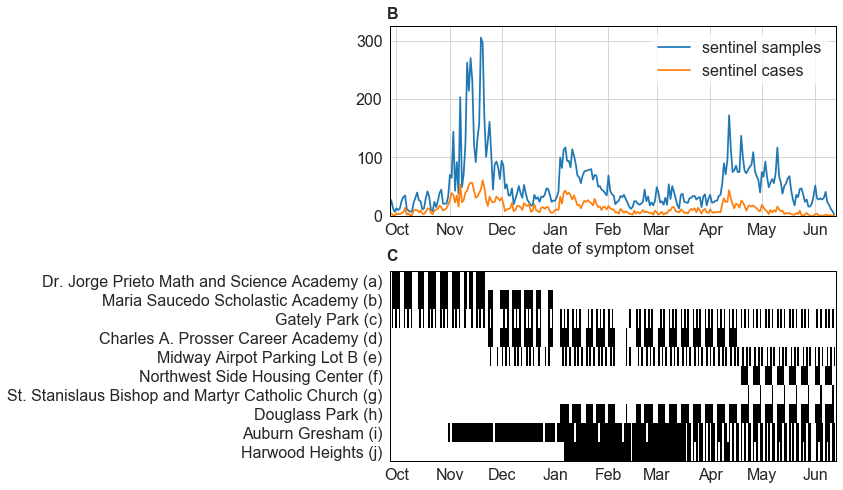

In [150]:
fig = plt.figure(figsize=(8,5))

palette = sns.color_palette()
fig = plt.figure(constrained_layout=False, figsize=(8,8))
gs = fig.add_gridspec(3, 1, height_ratios=[1.5,0.03,1.5])
axes = []

ax = fig.add_subplot(gs[0,0])
axes.append(ax)
window_start_date = dt.datetime(day=27, month=9, year=2020)
window_end_date = dt.datetime(day=13, month=6, year=2021)
ax.plot(combo_ss, color=sns.color_palette()[0], label='sentinel samples', linewidth=1.75)
ax.plot(combo_sc, color=sns.color_palette()[1], label='sentinel cases', linewidth=1.75)
#ax.plot(combo_adjust, color=sns.color_palette()[3], label='adjusted sentinel cases\n(cap = 40)')
#plt.plot(idph_adjust, color=sns.color_palette()[5], label='IDPH adjusted\nsentinel cases\n(cap = 10)')

ax.set_xlabel('date of symptom onset', fontsize=16)
#ax.set_yticks(np.arange(0,16,5))
#ax.set_ylim([0,20])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_locator(mdates.MonthLocator()) #ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis='both', labelsize=16) #loc = WeekdayLocator(byweekday=MO, interval=2)
#ax.grid(False, axis='y')
for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(1)
    ax.spines[pos].set_color('k')
ax.set_xlim([window_start_date, window_end_date])
ax.set_ylim([0,325])
leg = ax.legend(frameon=True, fontsize=16, loc='upper right', framealpha=0.75)
leg.get_frame().set_linewidth(0)

ax = fig.add_subplot(gs[2,0])
axes.append(ax)
mt = mdates.date2num((open_df.index[0],open_df.index[-1]))
ax.imshow(open_df.T, aspect='auto', extent=[mt[0], mt[1], 9, -1], cmap='binary')
#ax.tick_params(axis='both', labelsize=14)
#ax.xaxis_date()
mt = mdates.date2num((open_df.index[0],open_df.index[-1]))
ax.set_yticks(np.arange(-0.5,9.5))
ax.set_yticklabels(open_df.columns)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='both', labelsize=16)
#ax.tick_params(axis='y', direction='out', length=20, color='k', width=1)
ax.set_xlabel(None)
ax.grid(False)
for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(1)
    ax.spines[pos].set_color('k')
fig.text(y=0.9, x=0.13, s='B', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.48, x=0.13, s='C', va='center', ha='center', fontsize=16, weight='bold')
fig.savefig('fig_1_panel_b_c_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('fig_1_panel_b_c_' + today_str + '.pdf', bbox_inches='tight')

# quantify sentinel samples by test site

In [151]:
%%time

np.random.seed(2022)
# generating raw sentinel case and adjusted sentinel case time series
r_storage = []
for cap in [1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['test_date', 'positive', 'test_site']]).rename(columns={'test_date':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
        curative_short = pd.DataFrame(curative_slice[['collection_time', 
                                                      'positive', 
                                                      'testing_site', 'site_type']]).rename(columns={'collection_time':'date', 
                                                                                        'testing_site':'test_site'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)

CPU times: total: 2.38 s
Wall time: 2.38 s


In [152]:
site_dict = {'IDPH HARWOOD HEIGHTS COMMUNITY TESTING':'j',
            'IDPH COMMUNITY TESTING AUBURN GRESHAM':'i',
            'IDPH AUBURN GRESHAM COMMUNITY TESTING':'i',
            'Charles A. Prosser Career Academy':'d',
             'Charles A. Prosser Career Academy: Open Mon - Fri':'d',
             'ZZZZZDr. Jorge Prieto Math and Science Academy':'a',
            'Midway Community Based Testing':'e', 
             'Douglass Park':'h', 'Gately Park':'c', 
             'Dr. Jorge Prieto Math and Science Academy':'a', 
             'Dr. Jorge Prieto Math And Science Academy':'a',
             'Northwest Side Housing Center':'f', 
             'Maria Saucedo Scholastic Academy':'b', 'St Stanislaus Bishop and Martyr Catholic Church':'g'}

In [153]:
collect_cases['site_code'] = collect_cases['test_site'].apply(lambda x: site_dict.get(x))

In [154]:
collect_cases.loc[(collect_cases['site_type'] == 'Mobile'), 'site_code'] = 'k'

In [155]:
collect_cases.loc[((collect_cases['site_type'] == 'Static') & (collect_cases['site_code'].isna())), 'site_code'] = 'k'

In [156]:
np.sum(collect_cases['site_code'].isin(list('abcdefgh')))

5401

In [157]:
np.sum(collect_cases['site_code'].isin(list('ij')))

7478

In [158]:
np.sum(collect_cases['site_code'].isin(list('k')))

1073

In [159]:
collect_cases['site_code'].value_counts()

i    3777
j    3701
k    1073
d    1046
e    1021
h     978
c     737
a     624
f     499
b     437
g      59
Name: site_code, dtype: int64

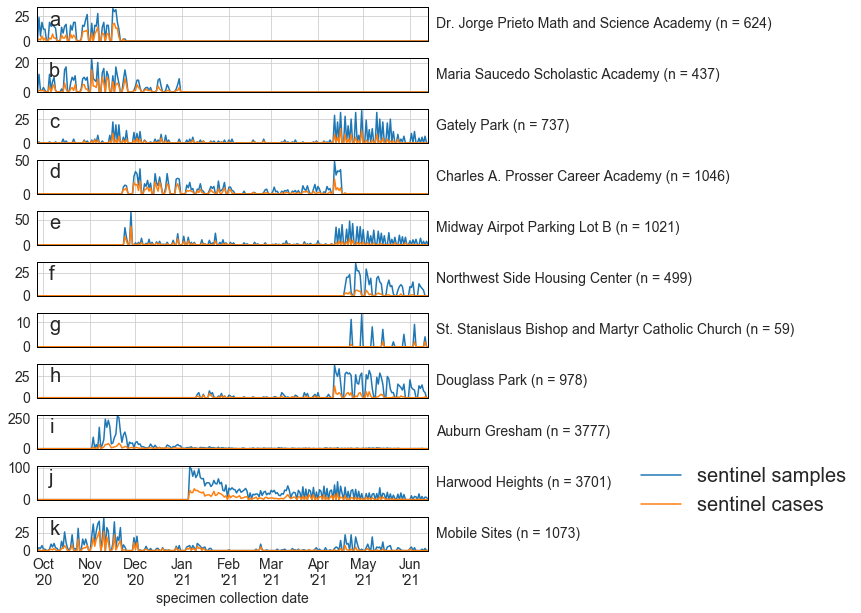

In [160]:
site_codes = list('abcdefghijk')
fig, axes = plt.subplots(ncols=1, nrows=len(site_codes), figsize=(7,10), gridspec_kw={'hspace':0.5})

site_names = ['Dr. Jorge Prieto Math and Science Academy','Maria Saucedo Scholastic Academy', 
        'Gately Park','Charles A. Prosser Career Academy', 'Midway Airpot Parking Lot B', 
        'Northwest Side Housing Center', 
              'St. Stanislaus Bishop and Martyr Catholic Church', 
              'Douglass Park', 'Auburn Gresham' , 'Harwood Heights', 'Mobile Sites']
window_start_date = pd.to_datetime(dt.datetime(day=27, month=9, year=2020), utc=True)
window_end_date = pd.to_datetime(dt.datetime(day=13, month=6, year=2021), utc=True)

for site_code, index, site_name in zip(site_codes, np.arange(len(site_codes)), site_names):
    collect_cases_slice = collect_cases[collect_cases['site_code'] == site_code]
    combo_sc = (collect_cases_slice['positive']).groupby(collect_cases_slice['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    
    ss_df_slice = collect_cases_slice[(collect_cases_slice['positive'] == True)]
    pos = ss_df_slice.groupby(['date']).count()['positive']
    pos = pos.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

    ss_df_slice = collect_cases_slice
    all_test = ss_df_slice.groupby(['date']).count()['positive']
    all_test = all_test.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)
    
    ax = axes[index]
    ax.plot(all_test, label='sentinel samples')
    ax.plot(pos, label='sentinel cases')
    #ax.plot(all_test)
    
    ax.set_xlim([window_start_date, window_end_date])
    
    ax.text(s=site_code, x=0.03, y=0.9, fontsize=20,
            transform=ax.transAxes, ha='left', va='top')
    ax.text(s=site_name + ' (n = ' + str(len(collect_cases_slice)) + ')', x=1.02, y=0.5, fontsize=14,
            transform=ax.transAxes, ha='left', va='center')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n'%y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_ylim(bottom=0)
    
    ax.tick_params(axis='both', labelsize=14)
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1)
        ax.spines[pos].set_color('k')

for ax in axes[0:len(site_codes)-1]:
    ax.set_xticklabels([])

for ax in axes:
    ax.tick_params(axis='both', labelsize=14)
    
axes[-1].set_xlabel('specimen collection date', fontsize=14)
axes[-2].legend(fontsize=20, frameon=False, loc='upper left', bbox_to_anchor=(1.5,1.5))
fig.savefig('tests_by_site_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('tests_by_site_' + today_str + '.pdf', bbox_inches='tight')

In [ ]:
np.random.seed(2022)
r_combo_adjust = covid19.r_covid(combo_adjust[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)

In [162]:
%%time

np.random.seed(2022)
# generating raw sentinel case and adjusted sentinel case time series
r_storage = []
for cap in [10,40,100,1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
        curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)
    np.random.seed(2022)
    r_combo_adjust = covid19.r_covid(combo_adjust[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_storage.append(r_combo_adjust.copy())

np.random.seed(2022)
r_combo_adjust = covid19.r_covid(combo_ss['positive'], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

tpr = pd.DataFrame(index = combo_sc.index, data={'cases':combo_ss['positive'].mean()*combo_sc.values.astype(int)/combo_ss['positive'].values})['cases']
np.random.seed(2022)
r_combo_adjust = covid19.r_covid(tpr[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

CPU times: total: 13.9 s
Wall time: 13.9 s


# Showing agreement between R(t) series

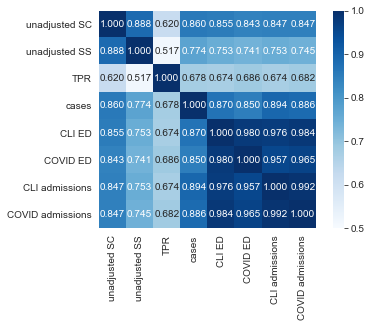

In [163]:
r_comparison_array = [r_storage[3], r_storage[4], r_storage[5], r_case, r_cli, r_cli_cdph, r_cli_ed, r_covid_ed]
r_comparison_array_labels = ['unadjusted SC', 'unadjusted SS', 'TPR', 'cases', 'CLI ED', 'COVID ED','CLI admissions', 'COVID admissions']

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])
        
sns.heatmap(similarity_matrix, vmin=0.5, vmax=1, cmap='Blues', annot=True, square=True, fmt='.3f',
            xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels)

SC
['2020-11-18T00:00:00.000000000' '2020-12-27T00:00:00.000000000'
 '2021-01-15T00:00:00.000000000' '2021-02-22T00:00:00.000000000'
 '2021-02-25T00:00:00.000000000' '2021-02-26T00:00:00.000000000'
 '2021-03-27T00:00:00.000000000' '2021-03-29T00:00:00.000000000'
 '2021-04-19T00:00:00.000000000']
SS
['2020-11-20T00:00:00.000000000' '2020-12-24T00:00:00.000000000'
 '2021-01-16T00:00:00.000000000' '2021-02-20T00:00:00.000000000'
 '2021-03-13T00:00:00.000000000' '2021-03-28T00:00:00.000000000'
 '2021-04-22T00:00:00.000000000']
SC/SS
['2020-11-02T00:00:00.000000000' '2020-11-22T00:00:00.000000000'
 '2020-12-20T00:00:00.000000000' '2021-01-05T00:00:00.000000000'
 '2021-01-14T00:00:00.000000000' '2021-01-23T00:00:00.000000000'
 '2021-01-29T00:00:00.000000000' '2021-03-05T00:00:00.000000000'
 '2021-03-26T00:00:00.000000000']
cases
['2020-05-01T00:00:00.000000000' '2020-06-16T00:00:00.000000000'
 '2020-08-23T00:00:00.000000000' '2020-09-11T00:00:00.000000000'
 '2020-11-12T00:00:00.000000000' '2

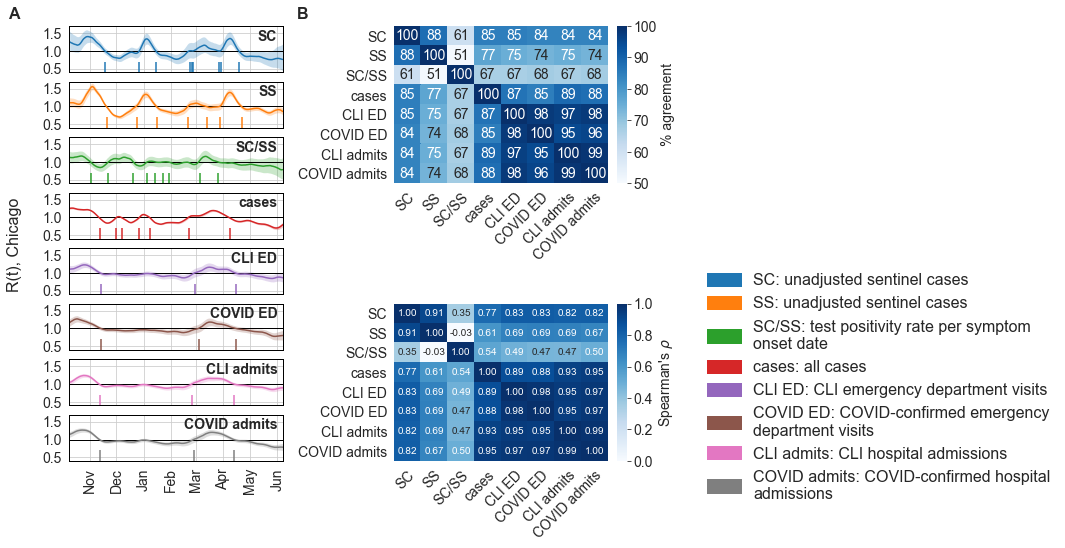

In [164]:
r_comparison_array = [r_storage[3], r_storage[4], r_storage[5], r_case, r_cli, r_cli_cdph, r_cli_ed, r_covid_ed]
r_comparison_array_labels = ['SC', 'SS', 'SC/SS', 'cases', 'CLI ED', 'COVID ED', 'CLI admits', 'COVID admits', ]

palette = sns.color_palette()
fig = plt.figure(constrained_layout=False, figsize=(10,8))
gs = fig.add_gridspec(len(r_comparison_array), 10, width_ratios=[1,1,1,1,2,1,1,1,1,0.2])
axes = []

for ii in range(len(r_comparison_array)):
    ax = fig.add_subplot(gs[ii,0:4])
    axes.append(ax)
    ax.axhline(1, linewidth=1, color='k', alpha=1)
    ax.plot(r_comparison_array[ii]['Q0.5'], linewidth=1.5, color=palette[ii])
    ax.fill_between(x=r_comparison_array[ii].index, 
                    y1=r_comparison_array[ii]['Q0.025'], 
                    y2=r_comparison_array[ii]['Q0.975'], 
                    alpha=0.25, linewidth=0, color=palette[ii])
    crossings_r = crossings(r_comparison_array[ii])
    ax.vlines(crossings_r, 
              ymin=0, ymax=0.7, linewidth=1.5, 
              color=palette[ii])
    print(r_comparison_array_labels[ii])
    print(crossings_r)
    ax.text(y=1.6, x=pd.to_datetime('2021-06-01', utc=True), 
            s=r_comparison_array_labels[ii], va='top', ha='right', fontsize=14, weight='bold')
    ax.set_ylim([0.4,1.7])
    ax.set_xlim([pd.to_datetime('2020-10-8', utc=True), pd.to_datetime('2021-06-07', utc=True)])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_xticklabels([])
    ax.set_yticks([0.5,1.00,1.5])
    ax.tick_params(axis='both', labelsize=14)
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1)
        ax.spines[pos].set_color('k')

fig.text(y=0.5, x=0.05, s='R(t), Chicago', va='center', ha='center', rotation=90, fontsize=16)
#fig.text(y=1, x=0.05, s='A', va='center', ha='center', fontsize=16, weight='bold')
axes[7].xaxis.set_tick_params(labelsize=14, rotation=90)
axes[7].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axes[7].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# agreement similarity matrix
ax = fig.add_subplot(gs[0:3,5:-1])
cbax = fig.add_subplot(gs[0:3,-1])
axes.append(ax)
axes.append(cbax)

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)

# spearman similarity matrix
ax = fig.add_subplot(gs[5:8,5:-1])
cbax = fig.add_subplot(gs[5:8,-1])
axes.append(ax)
axes.append(cbax)

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = spearmanr(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        
g = sns.heatmap((similarity_matrix), vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':10})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)



# legend
#cbax.set_title('% agreement', fontsize=14, ha='left', pad=10)
ax = fig.add_subplot(gs[4:,4:])
axes.append(ax)
ax.axis('off')
custom_lines = []
for color in palette[0:len(r_comparison_array)]:
        custom_lines.append(mpl.patches.Patch(color=color, lw=3))
long_array_labels = ['SC: unadjusted sentinel cases', 
                     'SS: unadjusted sentinel cases', 
                     'SC/SS: test positivity rate per symptom\nonset date', 
                     'cases: all cases',
                     'CLI ED: CLI emergency department visits ', 
                     'COVID ED: COVID-confirmed emergency\ndepartment visits', 
                     'CLI admits: CLI hospital admissions', 
                     'COVID admits: COVID-confirmed hospital\nadmissions']
ax.legend(custom_lines, long_array_labels, fontsize=16, 
          frameon=False, loc='upper left', bbox_to_anchor=(1.2,0.95), ncol=1)

fig.text(y=0.9, x=0.05, s='A', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.9, x=0.45, s='B', va='center', ha='center', fontsize=16, weight='bold')

fig.savefig('fig_3_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('fig_3_' + today_str + '.pdf', bbox_inches='tight')

# Show agreement before and after Feb 1

C:\Users\richa\AppData\Local\Temp\ipykernel_22948\60771426.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbax = fig.add_subplot(gs[0,-1])
C:\Users\richa\AppData\Local\Temp\ipykernel_22948\60771426.py:92: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbax = fig.add_subplot(gs[2,-1])


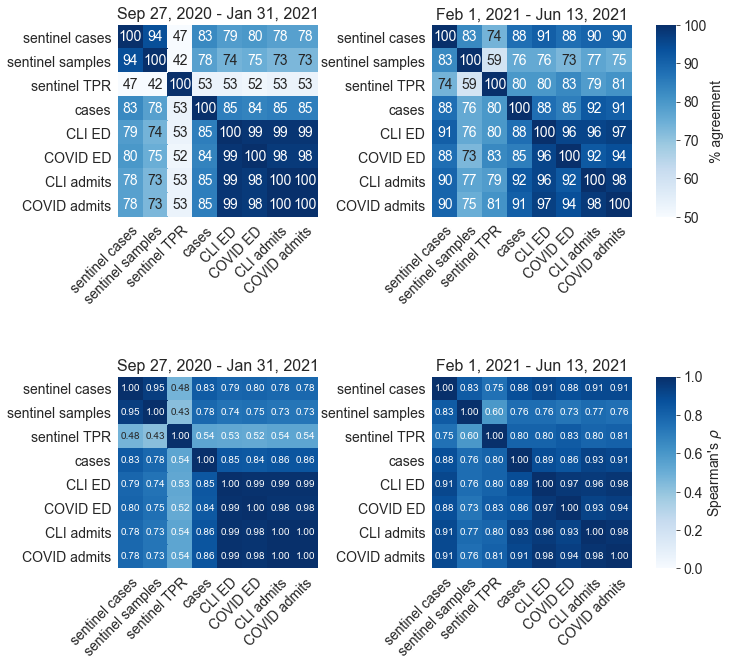

In [43]:
fig = plt.figure(constrained_layout=False, figsize=(10,10))
gs = fig.add_gridspec(3, 4, width_ratios=[1,0.33,1,0.1], height_ratios=[1,0.5,1])

r_comparison_array = [r_storage[3], r_storage[4], r_storage[5], r_case, r_cli, r_cli_cdph, r_cli_ed, r_covid_ed]
r_comparison_array_labels = ['sentinel cases', 'sentinel samples', 
                             'sentinel TPR', 'cases', 'CLI ED', 'COVID ED','CLI admits', 'COVID admits']

# early period agreement
similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-01-31', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[0,0])
cbax = fig.add_subplot(gs[0,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)
ax.set_title('Sep 27, 2020 - Jan 31, 2021', fontsize=16)

# late period agreement
similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2021-02-01', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[0,2])
cbax = fig.add_subplot(gs[0,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)
ax.set_title('Feb 1, 2021 - Jun 13, 2021', fontsize=16)

# early period spearman
similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-01-31', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[2,0])
cbax = fig.add_subplot(gs[2,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap(similarity_matrix, vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':10})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)
ax.set_title('Sep 27, 2020 - Jan 31, 2021', fontsize=16)

# late period Spearman
similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2021-02-01', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[2,2])
cbax = fig.add_subplot(gs[2,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap(similarity_matrix, vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':10})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)
ax.set_title('Feb 1, 2021 - Jun 13, 2021', fontsize=16)

fig.savefig('supp_fig_2_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_2_' + today_str + '.pdf', bbox_inches='tight')

# Show agreement with 7-day smoothing (instead of 14-day)

In [45]:
%%time
np.random.seed(2022)
# generating raw sentinel case and adjusted sentinel case time series
r_storage = []
for cap in [10,40,100,1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
        curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)
    np.random.seed(2022)
    r_combo_adjust = covid19.r_covid(combo_adjust[1:], delay_distribution=sc_distrb, r_window_size=7, auto_cutoff=True)
    r_storage.append(r_combo_adjust.copy())

np.random.seed(2022)
r_combo_adjust = covid19.r_covid(combo_ss['positive'], delay_distribution=sc_distrb, r_window_size=7, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

tpr = pd.DataFrame(index = combo_sc.index, data={'cases':combo_ss['positive'].mean()*combo_sc.values.astype(int)/combo_ss['positive'].values})['cases']
np.random.seed(2022)
r_combo_adjust = covid19.r_covid(tpr[1:], delay_distribution=sc_distrb, r_window_size=7, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

CPU times: total: 13.6 s
Wall time: 13.7 s


In [46]:
#Retrieving archived data
# CLI hospitalizations
cli = pd.read_csv('./data/CLI_admissions_210825.csv') #Good! This is actual CLI
cli['date'] = pd.to_datetime(cli['date'], utc=True)
cli_series = cli[cli['region'] == 'Chicago'].groupby('date').sum()['inpatient']

np.random.seed(2022)
r_cli = covid19.r_covid(cli_series, delay_distribution=cli_distrb, r_window_size=7, auto_cutoff=True)

# ED visits (CLI & covid-confirmed)
cli_ed = pd.read_csv('./data/ed_visits_chicago_210923.csv')
cli_ed['date'] = pd.to_datetime(cli_ed['date'], utc=True)

covid_ed_series = cli_ed.set_index('date')['total_covid_daily']
covid_ed_series = covid_ed_series.dropna()
np.random.seed(2022)
r_covid_ed = covid19.r_covid(covid_ed_series, delay_distribution=cli_distrb, r_window_size=7, auto_cutoff=True)

cli_ed_series = cli_ed.set_index('date')['total_cli_daily']
cli_ed_series = cli_ed_series.dropna()
np.random.seed(2022)
r_cli_ed = covid19.r_covid(cli_ed_series, delay_distribution=cli_distrb, r_window_size=7, auto_cutoff=True)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

cli_cdph_series = cli_cdph.set_index('date')['hospitalizations_total']
cli_cdph_series = cli_cdph_series.dropna()

np.random.seed(2022)
r_cli_cdph = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=7, auto_cutoff=True)
#r_cli_cdph_partial = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=False)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

# cases
case_series = cli_cdph.set_index('date')['cases_total']
case_series = case_series.dropna()
np.random.seed(2022)
r_case = covid19.r_covid(case_series, delay_distribution=case_distrb, r_window_size=7, auto_cutoff=True)

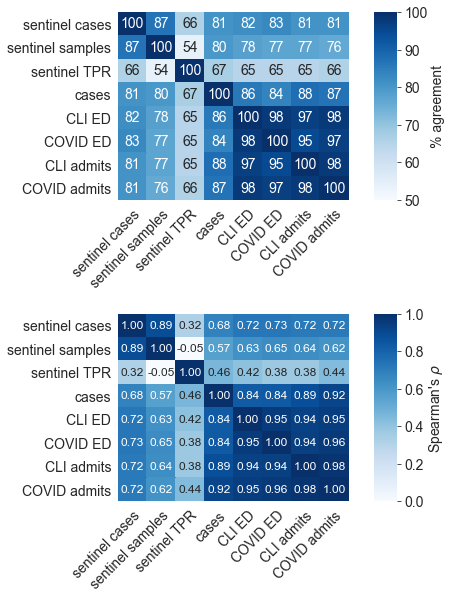

In [50]:
fig = plt.figure(constrained_layout=False, figsize=(5,9))
gs = fig.add_gridspec(3, 2, width_ratios=[1,0.1], height_ratios=[1,0.3,1])

r_comparison_array = [r_storage[3], r_storage[4], r_storage[5], r_case, r_cli, r_cli_cdph, r_cli_ed, r_covid_ed]
r_comparison_array_labels = ['sentinel cases', 'sentinel samples', 
                             'sentinel TPR', 'cases', 'CLI ED', 'COVID ED','CLI admits', 'COVID admits']

# agreement matrix
similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[0,0])
cbax = fig.add_subplot(gs[0,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)

# spearman similarity matrix
ax = fig.add_subplot(gs[2,0])
cbax = fig.add_subplot(gs[2,-1])
axes.append(ax)
axes.append(cbax)

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = spearmanr(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        
g = sns.heatmap((similarity_matrix), vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':12})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)

fig.savefig('supp_fig_3_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_3_' + today_str + '.pdf', bbox_inches='tight')

# Descriptive stats and age/race/eth

In [30]:
start_date = pd.to_datetime('09-27-2020')
end_date = pd.to_datetime('06-13-2021')
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
idph_slice = idph[idph_chicago_site &
                  chi_idph & 
                  (idph['test_date'] >= start_date) & 
                  (idph['test_date'] <= end_date)]
curative_slice = curative[(curative['collection_time'] >= start_date) & 
                          (curative['collection_time'] <= end_date)]

In [31]:
print('Total specimens collected: ' + str(len(curative_slice) + len(idph_slice)))

print('With date of symptom onset: ' + str(len(idph_slice.dropna(subset=['days'])) + len(curative_slice.dropna(subset=['days']))))

Total specimens collected: 324872
With date of symptom onset: 25908


In [32]:
races = ['White, Non-Latinx', 'Other, Non-Latinx', 'Asian, Non-Latinx', 'Black, Non-Latinx', 'Other, Non-Latinx', 'Unknown']
race_array = idph[['race_white',
                   'race_american_indian_alaskan', 
                   'race_asian', 
                   'race_black_african_american', 
                   'race_hawaiian_pacific_islander',
                   'race_unknown']].values == 'Yes'
clean_race_list = []
for row in race_array:
    if np.sum(row) == 1:
        clean_race_list.append(races[np.where(row)[0][0]])
    elif np.sum(row) == 0:
        clean_race_list.append('Unknown')
    elif np.sum(row) > 1:
        clean_race_list.append('Other, Non-Latinx')
        
eth_array = idph['ethnicity'].values

race_cdph_list = []
for race, eth in zip(clean_race_list, eth_array):
    if eth == 'Hispanic or Latino':
        race_cdph_list.append('Latinx')
    elif eth == 'Non Hispanic or Latino':
        race_cdph_list.append(race)
    else:
        race_cdph_list.append('Unknown')

In [33]:
idph['cdph_race'] = race_cdph_list

In [34]:
idph_age_list = list(pd.cut(x=idph['age'].values.astype(int), bins=[-1,17,29,39,49,59,69,79,116], 
       labels=['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']))
idph['age_group'] = idph_age_list

In [35]:
start_date = pd.to_datetime('09-27-2020')
end_date = pd.to_datetime('06-13-2021')
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
idph_slice = idph[ss_cond & idph_chicago_site &
                  idph['chicago'] & 
                  chi_idph & 
                  (idph['test_date'] >= start_date) & 
                  (idph['test_date'] <= end_date)]
curative_slice = curative[curative['chicago'] &
                          (curative['collection_time'] >= start_date) & 
                          (curative['collection_time'] <= end_date) &
                          (curative['days'] >= 0) & 
                          (curative['days'] <= 4)]

sentinel_race_breakdown = idph_slice['cdph_race'].value_counts() + curative_slice['cdph_race'].value_counts()
sentinel_race_breakdown = sentinel_race_breakdown.rename({'Latinx':'Hispanic/Latino',
                                'Asian, Non-Latinx':'Asian, Non-Hispanic',
                                'Black, Non-Latinx':'Black, Non-Hispanic',
                                'White, Non-Latinx':'White, Non-Hispanic', 
                                'Other, Non-Latinx':'Other, Non-Hispanic', 
                                'Unknown':'Unknown'})

In [36]:
value_counts = idph_slice['test_site'].value_counts()
value_counts_index = [(obj.find('MOBILE') != -1) for obj in idph_slice['test_site'].value_counts().index]
mobile = curative_slice['site_type'].value_counts()['Mobile'] + value_counts[value_counts_index].sum()
print('Total mobile site SS: ' + str(mobile))
print('Total static site SS: ' + str(len(idph_slice) + len(curative_slice) - mobile))
print('Total: ' + str(len(idph_slice) + len(curative_slice)))

Total mobile site SS: 1067
Total static site SS: 12885
Total: 13952


In [37]:
curative_slice['site_type'].value_counts()

Static    5407
Mobile    1067
Name: site_type, dtype: int64

In [38]:
curative_age_list = list(pd.cut(x=curative_slice['age_at_test'].values.astype(int), bins=[-1,17,29,39,49,59,69,79,116], 
       labels=['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']))
idph_age_list = list(pd.cut(x=idph_slice['age'].values.astype(int), bins=[-1,17,29,39,49,59,69,79,116], 
       labels=['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']))
sentinel_age_list = curative_age_list + idph_age_list
sentinel_age_breakdown = pd.Series(sentinel_age_list).value_counts()

In [39]:
idx = pd.date_range('9-24-2020', '06-14-2021')
ss_df = pd.concat([idph_slice[['date_symptoms_start', 'positive']].rename(columns={'date_symptoms_start':'date'}),
           curative_slice[['patient_symptom_date', 'positive']].rename(columns={'patient_symptom_date':'date'})])
ss_df['date'] = pd.to_datetime(ss_df['date'], utc=True)
#ss_df = ss_df.set_index('date')

ss_df_slice = ss_df[(ss_df['positive'] == True)]
pos = ss_df_slice.groupby(['date']).count()['positive']
pos = pos.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

ss_df_slice = ss_df
all_test = ss_df_slice.groupby(['date']).count()['positive']
all_test = all_test.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

pos_sentinel = pos
all_test_sentinel = all_test

# check against all tests at sentinel sites

In [112]:
start_date = pd.to_datetime('09-27-2020')
end_date = pd.to_datetime('06-13-2021')
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
idph_slice = idph[idph_chicago_site &
                  (idph['test_date'] >= start_date) & 
                  (idph['test_date'] <= end_date)]
curative_slice = curative[(curative['collection_time'] >= start_date) & 
                          (curative['collection_time'] <= end_date)]

site_race_breakdown = idph_slice['cdph_race'].value_counts() + curative_slice['cdph_race'].value_counts()
site_race_breakdown = site_race_breakdown.rename({'Latinx':'Hispanic/Latino',
                                'Asian, Non-Latinx':'Asian, Non-Hispanic',
                                'Black, Non-Latinx':'Black, Non-Hispanic',
                                'White, Non-Latinx':'White, Non-Hispanic', 
                                'Other, Non-Latinx':'Other, Non-Hispanic', 
                                'Unknown':'Unknown'})
curative['age_group'] = curative['age_group'].replace({'#VALUE!':'Unknown'})

curative_age_list = list(curative_slice['age_group'])#list(pd.cut(x=curative_slice['age_at_test'].values.astype(int), bins=[-1,17,29,39,49,59,69,79,116], 
       #labels=['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']))
idph_age_list = list(pd.cut(x=idph_slice['age'].values.astype(int), bins=[-1,17,29,39,49,59,69,79,116], 
       labels=['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']))
sentinel_age_list = curative_age_list + idph_age_list
site_age_breakdown = pd.Series(sentinel_age_list).value_counts()

idx = pd.date_range('9-27-2020', '06-13-2021')
ss_df = pd.concat([idph_slice[['test_date', 'positive']].rename(columns={'test_date':'date'}),
           curative_slice[['collection_time', 'positive']].rename(columns={'collection_time':'date'})])
ss_df['date'] = pd.to_datetime(ss_df['date'], utc=True)
#ss_df = ss_df.set_index('date')

ss_df_slice = ss_df[(ss_df['positive'] == True)]
pos = ss_df_slice.groupby(['date']).count()['positive']
pos = pos.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

ss_df_slice = ss_df
all_test = ss_df_slice.groupby(['date']).count()['positive']
all_test = all_test.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

pos_site = pos
all_test_site = all_test

In [113]:
race_breakdown = pd.concat([pd.DataFrame(sentinel_race_breakdown), 
                            pd.DataFrame(site_race_breakdown)], axis=1)

race_breakdown.columns = ['sentinel', 'sites']

race_breakdown = race_breakdown.reindex(['Hispanic/Latino', 
                        'Black, Non-Hispanic', 
                        'White, Non-Hispanic', 
                        'Asian, Non-Hispanic', 
                        'Other, Non-Hispanic', 
                        'Unknown']).fillna(0.0).astype(int)

In [114]:
age_breakdown = pd.concat([pd.DataFrame(sentinel_age_breakdown), 
                            pd.DataFrame(site_age_breakdown)], axis=1)

age_breakdown.columns = ['sentinel', 'sites']

age_breakdown = age_breakdown.reindex(['Unknown','0-17',
                                       '18-29',
                                       '30-39',
                                       '40-49',
                                       '50-59',
                                       '60-69',
                                       '70-79',
                                       '80+']).fillna(0.0).astype(int)

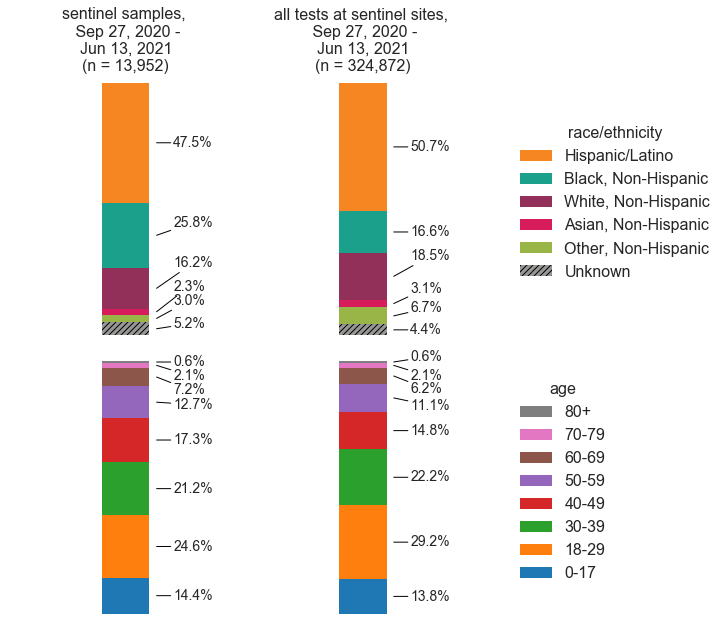

In [115]:
race_palette = ['#f68621', '#1ba18b', '#923059', '#d61c5b', '#99b547', '#979796']
age_palette = sns.color_palette()

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8.5, 10))
width = 0.2
y1 = race_breakdown.loc['Hispanic/Latino'].values/race_breakdown.sum().values
y2 = race_breakdown.loc['Black, Non-Hispanic'].values/race_breakdown.sum().values
y3 = race_breakdown.loc['White, Non-Hispanic'].values/race_breakdown.sum().values
y4 = race_breakdown.loc['Asian, Non-Hispanic'].values/race_breakdown.sum().values
y5 = race_breakdown.loc['Other, Non-Hispanic'].values/race_breakdown.sum().values
y6 = race_breakdown.loc['Unknown'].values/race_breakdown.sum().values

x_arr = [0,1]

axes[0].bar(x=x_arr, 
            bottom=0, height=y6, 
            color=race_palette[5], 
            width=width, hatch='////', edgecolor='k', linewidth=0, 
            label=race_breakdown.index[5])
axes[0].bar(x=x_arr, 
            bottom=y6, height=y5, 
            color=race_palette[4], 
            width=width, linewidth=0, 
            label=race_breakdown.index[4])
axes[0].bar(x=x_arr, 
            bottom=y6+y5, height=y4, 
            color=race_palette[3], 
            width=width, linewidth=0, 
            label=race_breakdown.index[3])
axes[0].bar(x=x_arr, 
            bottom=y6+y5+y4, height=y3, 
            color=race_palette[2], 
            width=width, linewidth=0, 
            label=race_breakdown.index[2])
axes[0].bar(x=x_arr, 
            bottom=y6+y5+y4+y3, height=y2, 
            color=race_palette[1], 
            width=width, linewidth=0, 
            label=race_breakdown.index[1])
axes[0].bar(x=x_arr, 
            bottom=y6+y5+y4+y3+y2, height=y1, 
            color=race_palette[0], 
            width=width, linewidth=0, 
            label=race_breakdown.index[0])
#u_bars.set_hatch('/')
axes[0].axis('off')
axes[0].set_xlim([-0.5,1.5])
handles, labels = axes[0].get_legend_handles_labels()
leg1 = axes[0].legend(handles[::-1], 
                      labels[::-1], 
                      title='race/ethnicity', 
                      loc='center left', 
                      fontsize=16, 
                      frameon=False, bbox_to_anchor=(1.05,0.5))
plt.setp(leg1.get_title(), fontsize=16)

sentinel = race_breakdown['sentinel'].values/race_breakdown['sentinel'].sum()
y_adjust_sentinel = [0,0.05,0.1,0.10,0.07,0.02,0]
hosp = race_breakdown['sites'].values/race_breakdown['sites'].sum()
y_adjust_hosp = [0,0.0,0.08,0.06,0.03,0]
for ele in range(6):
    sentinel_height = 1 - sentinel[0:ele].sum() - sentinel[ele]/2
    axes[0].annotate(s="{:.1f}%".format(100*sentinel[ele]), 
                     xy=(0+width/2+0.03, sentinel_height), 
                     xytext=(0+width/2+0.10, sentinel_height+y_adjust_sentinel[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    hosp_height = 1 - hosp[0:ele].sum() - hosp[ele]/2
    axes[0].annotate(s="{:.1f}%".format(100*hosp[ele]), 
                     xy=(1+width/2+0.03, hosp_height), 
                     xytext=(1+width/2+0.10, hosp_height+y_adjust_hosp[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
        
axes[0].text(s='sentinel samples, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(race_breakdown['sentinel'].sum()) + ')', 
             x=0, y=1.3, va='top', ha='center', fontsize=16)
axes[0].text(s='all tests at sentinel sites, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(race_breakdown['sites'].sum()) + ')', 
             x=1, y=1.3, va='top', ha='center', fontsize=16)

y1 = age_breakdown.loc['80+'].values/age_breakdown.sum().values
y2 = age_breakdown.loc['70-79'].values/age_breakdown.sum().values
y3 = age_breakdown.loc['60-69'].values/age_breakdown.sum().values
y4 = age_breakdown.loc['50-59'].values/age_breakdown.sum().values
y5 = age_breakdown.loc['40-49'].values/age_breakdown.sum().values
y6 = age_breakdown.loc['30-39'].values/age_breakdown.sum().values
y7 = age_breakdown.loc['18-29'].values/age_breakdown.sum().values
y8 = age_breakdown.loc['0-17'].values/age_breakdown.sum().values
y9 = age_breakdown.loc['Unknown'].values/age_breakdown.sum().values




axes[1].bar(x=x_arr, 
            bottom=y9, height=y8, 
            color=age_palette[0], 
            width=width, linewidth=0, 
            label='0-17')
axes[1].bar(x=x_arr, 
            bottom=y9+y8, height=y7, 
            color=age_palette[1], 
            width=width, linewidth=0, 
            label='18-29')
axes[1].bar(x=x_arr, 
            bottom=y9+y8+y7, height=y6, 
            color=age_palette[2], 
            width=width, linewidth=0, 
            label='30-39')
axes[1].bar(x=x_arr, 
            bottom=y9+y8+y7+y6, height=y5, 
            color=age_palette[3], 
            width=width, linewidth=0, 
            label='40-49')
axes[1].bar(x=x_arr, 
            bottom=y9+y8+y7+y6+y5, height=y4, 
            color=age_palette[4], 
            width=width, linewidth=0, 
            label='50-59')
axes[1].bar(x=x_arr, 
            bottom=y9+y8+y7+y6+y5+y4, height=y3, 
            color=age_palette[5], 
            width=width, linewidth=0, 
            label='60-69')
axes[1].bar(x=x_arr, 
            bottom=y9+y8+y7+y6+y5+y4+y3, height=y2, 
            color=age_palette[6], 
            width=width, linewidth=0, 
            label='70-79')
axes[1].bar(x=x_arr, 
            bottom=y9+y8+y7+y6+y5+y4+y3+y2, height=y1, 
            color=age_palette[7], 
            width=width, linewidth=0, 
            label='80+')
#u_bars.set_hatch('/')
axes[1].axis('off')
axes[1].set_xlim([-0.5,1.5])
handles, labels = axes[1].get_legend_handles_labels()
leg2 = axes[1].legend(handles[::-1], 
                      labels[::-1], 
                      title='age', 
                      loc='center left', 
                      fontsize=16, 
                      frameon=False, bbox_to_anchor=(1.05,0.5))
plt.setp(leg2.get_title(), fontsize=16)

sentinel = age_breakdown['sentinel'].values/age_breakdown['sentinel'].sum()
y_adjust_sentinel = [0,0,0,0,0,-0.01,-0.05,-0.04,0]
hosp = age_breakdown['sites'].values/age_breakdown['sites'].sum()
y_adjust_hosp = [0,0,0,0,0,-0.03,-0.05,-0.04,0.02]

for ele in [8,7,6,5,4,3,2,1]:
    sentinel_height = 0 + sentinel[0:ele].sum() + sentinel[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*sentinel[ele]), 
                     xy=(0+width/2+0.03, sentinel_height), 
                     xytext=(0+width/2+0.10, sentinel_height+y_adjust_sentinel[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    hosp_height = 0 + hosp[0:ele].sum() + hosp[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*hosp[ele]), 
                     xy=(1+width/2+0.03, hosp_height), 
                     xytext=(1+width/2+0.10, hosp_height+y_adjust_hosp[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
        
plt.subplots_adjust(wspace=0, hspace=0.05)
fig.savefig('sentinel_samples_vs_test_sites_demo_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('sentinel_samples_vs_test_sites_demo_' + today_str + '.pdf', bbox_inches='tight')

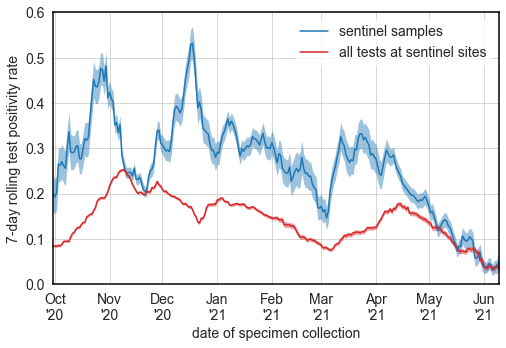

In [116]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()

# sentinel
color_str = sns.color_palette()[0]
pos = pos_sentinel.rolling(window=7, center=True).sum()
all_test = all_test_sentinel.rolling(window=7, center=True).sum()
p = pos/all_test
se = np.sqrt(p*(1-p)/all_test)

ax.plot(p, color=color_str, label='sentinel samples')
ax.fill_between(x=p.index, y1=p-se, y2=p+se, color=color_str, alpha=0.25, linewidth=0)
ax.fill_between(x=p.index, y1=p-se, y2=p+se, color=color_str, alpha=0.25, linewidth=0)

# all at sentinel site
color_str = sns.color_palette()[3]
pos = pos_site.rolling(window=7, center=True).sum()
all_test = all_test_site.rolling(window=7, center=True).sum()
p = pos/all_test
se = np.sqrt(p*(1-p)/all_test)

ax.plot(p, color=color_str, label='all tests at sentinel sites')
ax.fill_between(x=p.index, y1=p-se, y2=p+se, color=color_str, alpha=0.25, linewidth=0)
ax.fill_between(x=p.index, y1=p-se, y2=p+se, color=color_str, alpha=0.25, linewidth=0)

for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(labelsize=14, axis='both', direction='out', width=1.5, length=5, color='k')
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
ax.set_xlim([pd.to_datetime('9-30-2020'), 
                      pd.to_datetime('6-10-2021')])
ax.set_ylim([0,0.6])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n'%y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.set_xlabel('date of specimen collection', fontsize=14)
ax.set_ylabel('7-day rolling test positivity rate', fontsize=14)

leg = ax.legend(fontsize=14, framealpha=0.75)
leg.get_frame().set_linewidth(0.0)

fig.savefig('sentinel_samples_vs_test_sites_positivity_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('sentinel_samples_vs_test_sites_positivity_' + today_str + '.pdf', bbox_inches='tight')

# check against all indicators

In [677]:
chi_demo = pd.read_csv('https://data.cityofchicago.org/resource/85cm-7uqa.csv')
chi_demo_slice = chi_demo[(chi_demo['geography_type'] == 'Citywide') & (chi_demo['year'] == 2019)]
chi_age_breakdown = chi_demo_slice[['population_age_0_17', 'population_age_18_29', 'population_age_30_39',
       'population_age_40_49', 'population_age_50_59', 'population_age_60_69',
       'population_age_70_79', 'population_age_80']].sum(axis=0).rename({'population_age_0_17':'0-17', 
                                                                      'population_age_18_29':'18-29', 
                                                                      'population_age_30_39':'30-39',
                                                                      'population_age_40_49':'40-49',
                                                                      'population_age_50_59':'50-59',
                                                                      'population_age_60_69':'60-69',
                                                                      'population_age_70_79':'70-79', 
                                                                      'population_age_80':'80+', 
                                                                      'population_age_unknown':'Unknown'})

chi_race_breakdown = chi_demo_slice[['population_latinx', 'population_asian_non_latinx',
       'population_black_non_latinx', 'population_white_non_latinx',
       'population_other_race_non']].sum(axis=0)
chi_race_breakdown = chi_race_breakdown.rename(
    {'population_latinx':'Hispanic/Latino',
     'population_asian_non_latinx':'Asian, Non-Hispanic',
     'population_black_non_latinx':'Black, Non-Hispanic',
     'population_white_non_latinx':'White, Non-Hispanic', 
     'population_other_race_non':'Other, Non-Hispanic', 
     'population_unknown_race_ethnicity':'Unknown'})

In [678]:
start_date = pd.to_datetime('09-27-2020', utc=True)
end_date = pd.to_datetime('06-13-2021', utc=True)
cli_cdph_slice = cli_cdph[(cli_cdph['date'] >= start_date) & (cli_cdph['date'] <= end_date)]

hospitalization_age_breakdown = cli_cdph_slice[['hospitalizations_age_0_17', 'hospitalizations_age_18_29',
       'hospitalizations_age_30_39', 'hospitalizations_age_40_49',
       'hospitalizations_age_50_59', 'hospitalizations_age_60_69',
       'hospitalizations_age_70_79', 'hospitalizations_age_80_', 
       'hospitalizations_age_unknown']].sum(axis=0)
hospitalization_age_breakdown = hospitalization_age_breakdown.rename({'hospitalizations_age_0_17':'0-17', 
                                                                      'hospitalizations_age_18_29':'18-29', 
                                                                      'hospitalizations_age_30_39':'30-39',
                                                                      'hospitalizations_age_40_49':'40-49',
                                                                      'hospitalizations_age_50_59':'50-59',
                                                                      'hospitalizations_age_60_69':'60-69',
                                                                      'hospitalizations_age_70_79':'70-79', 
                                                                      'hospitalizations_age_80_':'80+', 
                                                                      'hospitalizations_age_unknown':'Unknown'})

hospitalization_race_breakdown = cli_cdph_slice[['hospitalizations_latinx', 'hospitalizations_asian_non_latinx',
       'hospitalizations_black_non_latinx',
       'hospitalizations_white_non_latinx',
       'hospitalizations_other_race_non_latinx',
       'hospitalizations_unknown_race_ethnicity']].sum(axis=0)
hospitalization_race_breakdown = hospitalization_race_breakdown.rename(
    {'hospitalizations_latinx':'Hispanic/Latino',
     'hospitalizations_asian_non_latinx':'Asian, Non-Hispanic',
     'hospitalizations_black_non_latinx':'Black, Non-Hispanic',
     'hospitalizations_white_non_latinx':'White, Non-Hispanic', 
     'hospitalizations_other_race_non_latinx':'Other, Non-Hispanic', 
     'hospitalizations_unknown_race_ethnicity':'Unknown'})

In [679]:
race_breakdown = pd.concat([pd.DataFrame(sentinel_race_breakdown), 
                            pd.DataFrame(hospitalization_race_breakdown), 
                            pd.DataFrame(chi_race_breakdown)], axis=1)

race_breakdown.columns = ['sentinel', 'hospitalizations', 'population']

race_breakdown = race_breakdown.reindex(['Hispanic/Latino', 
                        'Black, Non-Hispanic', 
                        'White, Non-Hispanic', 
                        'Asian, Non-Hispanic', 
                        'Other, Non-Hispanic', 
                        'Unknown']).fillna(0.0).astype(int)

In [680]:
age_breakdown = pd.concat([pd.DataFrame(sentinel_age_breakdown), 
                            pd.DataFrame(hospitalization_age_breakdown), 
                            pd.DataFrame(chi_age_breakdown)], axis=1)

age_breakdown.columns = ['sentinel', 'hospitalizations', 'population']

age_breakdown = age_breakdown.reindex(['Unknown','0-17',
                                       '18-29',
                                       '30-39',
                                       '40-49',
                                       '50-59',
                                       '60-69',
                                       '70-79',
                                       '80+']).fillna(0.0).astype(int)

In [681]:
race_palette = ['#f68621', '#1ba18b', '#923059', '#8972b3', '#787878', '#ffffff']

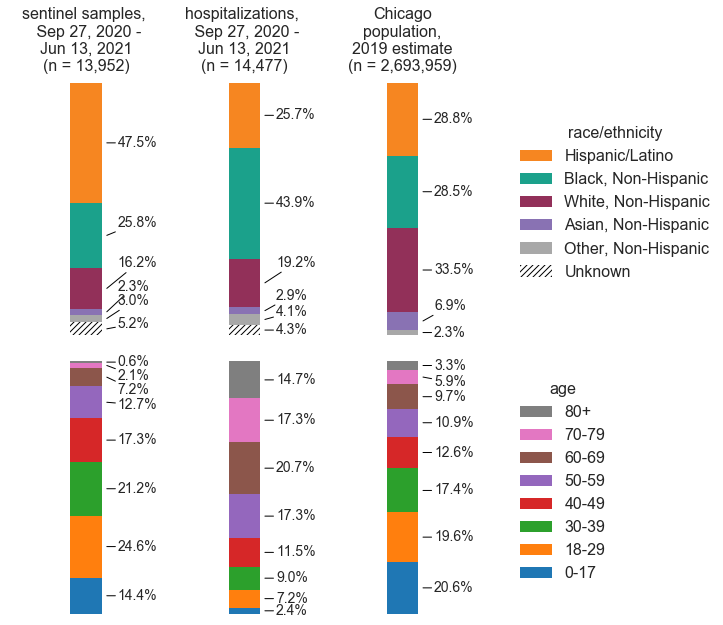

In [682]:
race_palette = ['#f68621', '#1ba18b', '#923059', '#8972b3', '#a8a8a8', '#ffffff']
age_palette = sns.color_palette()

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8.5, 10))
width = 0.2
y1 = race_breakdown.loc['Hispanic/Latino'].values/race_breakdown.sum().values
y2 = race_breakdown.loc['Black, Non-Hispanic'].values/race_breakdown.sum().values
y3 = race_breakdown.loc['White, Non-Hispanic'].values/race_breakdown.sum().values
y4 = race_breakdown.loc['Asian, Non-Hispanic'].values/race_breakdown.sum().values
y5 = race_breakdown.loc['Other, Non-Hispanic'].values/race_breakdown.sum().values
y6 = race_breakdown.loc['Unknown'].values/race_breakdown.sum().values
axes[0].bar(x=[0, 1, 2], 
            bottom=0, height=y6, 
            color=race_palette[5], 
            width=width, hatch='////', edgecolor='k', linewidth=0, 
            label=race_breakdown.index[5])
axes[0].bar(x=[0, 1, 2], 
            bottom=y6, height=y5, 
            color=race_palette[4], 
            width=width, linewidth=0, 
            label=race_breakdown.index[4])
axes[0].bar(x=[0, 1, 2], 
            bottom=y6+y5, height=y4, 
            color=race_palette[3], 
            width=width, linewidth=0, 
            label=race_breakdown.index[3])
axes[0].bar(x=[0, 1, 2], 
            bottom=y6+y5+y4, height=y3, 
            color=race_palette[2], 
            width=width, linewidth=0, 
            label=race_breakdown.index[2])
axes[0].bar(x=[0, 1, 2], 
            bottom=y6+y5+y4+y3, height=y2, 
            color=race_palette[1], 
            width=width, linewidth=0, 
            label=race_breakdown.index[1])
axes[0].bar(x=[0, 1, 2], 
            bottom=y6+y5+y4+y3+y2, height=y1, 
            color=race_palette[0], 
            width=width, linewidth=0, 
            label=race_breakdown.index[0])
#u_bars.set_hatch('/')
axes[0].axis('off')
axes[0].set_xlim([-0.5,2.5])
handles, labels = axes[0].get_legend_handles_labels()
leg1 = axes[0].legend(handles[::-1], 
                      labels[::-1], 
                      title='race/ethnicity', 
                      loc='center left', 
                      fontsize=16, 
                      frameon=False, bbox_to_anchor=(1.05,0.5))
plt.setp(leg1.get_title(), fontsize=16)

sentinel = race_breakdown['sentinel'].values/race_breakdown['sentinel'].sum()
y_adjust_sentinel = [0,0.05,0.1,0.10,0.07,0.02,0]
hosp = race_breakdown['hospitalizations'].values/race_breakdown['hospitalizations'].sum()
y_adjust_hosp = [0,0.0,0.08,0.06,0.03,0]
pop = race_breakdown['population'].values/race_breakdown['population'].sum()
y_adjust_pop = [0,0.0,0.0,0.06,0.0,0]
for ele in range(6):
    sentinel_height = 1 - sentinel[0:ele].sum() - sentinel[ele]/2
    axes[0].annotate(s="{:.1f}%".format(100*sentinel[ele]), 
                     xy=(0+width/2+0.03, sentinel_height), 
                     xytext=(0+width/2+0.10, sentinel_height+y_adjust_sentinel[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    hosp_height = 1 - hosp[0:ele].sum() - hosp[ele]/2
    axes[0].annotate(s="{:.1f}%".format(100*hosp[ele]), 
                     xy=(1+width/2+0.03, hosp_height), 
                     xytext=(1+width/2+0.10, hosp_height+y_adjust_hosp[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    pop_height = 1 - pop[0:ele].sum() - pop[ele]/2
    if pop[ele] != 0.0:
        axes[0].annotate(s="{:.1f}%".format(100*pop[ele]), 
                         xy=(2+width/2+0.03, pop_height), 
                         xytext=(2+width/2+0.10, pop_height+y_adjust_pop[ele]), va='center', ha='left',
                         arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                         fontsize=14)
        
axes[0].text(s='sentinel samples, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(race_breakdown['sentinel'].sum()) + ')', 
             x=0, y=1.3, va='top', ha='center', fontsize=16)
axes[0].text(s='hospitalizations, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(race_breakdown['hospitalizations'].sum()) + ')', 
             x=1, y=1.3, va='top', ha='center', fontsize=16)
axes[0].text(s='Chicago\npopulation,\n2019 estimate\n(n = ' + '{:,}'.format(race_breakdown['population'].sum()) + ')', 
             x=2, y=1.3, va='top', ha='center', fontsize=16)

y1 = age_breakdown.loc['80+'].values/age_breakdown.sum().values
y2 = age_breakdown.loc['70-79'].values/age_breakdown.sum().values
y3 = age_breakdown.loc['60-69'].values/age_breakdown.sum().values
y4 = age_breakdown.loc['50-59'].values/age_breakdown.sum().values
y5 = age_breakdown.loc['40-49'].values/age_breakdown.sum().values
y6 = age_breakdown.loc['30-39'].values/age_breakdown.sum().values
y7 = age_breakdown.loc['18-29'].values/age_breakdown.sum().values
y8 = age_breakdown.loc['0-17'].values/age_breakdown.sum().values
y9 = age_breakdown.loc['Unknown'].values/age_breakdown.sum().values
#axes[1].bar(x=[0, 1, 2], 
#            bottom=0, height=y9, 
#            color='w', 
#            width=width, hatch='////', edgecolor='k', linewidth=0, 
#            label='Unknown')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9, height=y8, 
            color=age_palette[0], 
            width=width, linewidth=0, 
            label='0-17')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8, height=y7, 
            color=age_palette[1], 
            width=width, linewidth=0, 
            label='18-29')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8+y7, height=y6, 
            color=age_palette[2], 
            width=width, linewidth=0, 
            label='30-39')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8+y7+y6, height=y5, 
            color=age_palette[3], 
            width=width, linewidth=0, 
            label='40-49')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8+y7+y6+y5, height=y4, 
            color=age_palette[4], 
            width=width, linewidth=0, 
            label='50-59')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8+y7+y6+y5+y4, height=y3, 
            color=age_palette[5], 
            width=width, linewidth=0, 
            label='60-69')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8+y7+y6+y5+y4+y3, height=y2, 
            color=age_palette[6], 
            width=width, linewidth=0, 
            label='70-79')
axes[1].bar(x=[0, 1, 2], 
            bottom=y9+y8+y7+y6+y5+y4+y3+y2, height=y1, 
            color=age_palette[7], 
            width=width, linewidth=0, 
            label='80+')
#u_bars.set_hatch('/')
axes[1].axis('off')
axes[1].set_xlim([-0.5,2.5])
handles, labels = axes[1].get_legend_handles_labels()
leg2 = axes[1].legend(handles[::-1], 
                      labels[::-1], 
                      title='age', 
                      loc='center left', 
                      fontsize=16, 
                      frameon=False, bbox_to_anchor=(1.05,0.5))
plt.setp(leg2.get_title(), fontsize=16)

sentinel = age_breakdown['sentinel'].values/age_breakdown['sentinel'].sum()
y_adjust_sentinel = [0,0,0,0,0,-0.01,-0.05,-0.04,0]
hosp = age_breakdown['hospitalizations'].values/age_breakdown['hospitalizations'].sum()
y_adjust_hosp = [0,0,0,0,0,0,0,0,0]
pop = age_breakdown['population'].values/age_breakdown['population'].sum()
y_adjust_pop = [0,0,0,0,0,0,0,-0.02,0]

for ele in [8,7,6,5,4,3,2,1]:
    sentinel_height = 0 + sentinel[0:ele].sum() + sentinel[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*sentinel[ele]), 
                     xy=(0+width/2+0.03, sentinel_height), 
                     xytext=(0+width/2+0.10, sentinel_height+y_adjust_sentinel[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    hosp_height = 0 + hosp[0:ele].sum() + hosp[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*hosp[ele]), 
                     xy=(1+width/2+0.03, hosp_height), 
                     xytext=(1+width/2+0.10, hosp_height+y_adjust_hosp[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    pop_height = 0 + pop[0:ele].sum() + pop[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*pop[ele]), 
                     xy=(2+width/2+0.03, pop_height), 
                     xytext=(2+width/2+0.10, pop_height+y_adjust_pop[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
        
plt.subplots_adjust(wspace=0, hspace=0.05)
fig.savefig('fig_2_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('fig_2_' + today_str + '.pdf', bbox_inches='tight')

In [683]:
# import age-stratified ED visits
ed_age = pd.read_csv('./data/220209_age_ed_visits_all.csv')
ed_age['date'] = pd.to_datetime(ed_age['date'], utc=True)

In [684]:
ed_age_slice = ed_age[(ed_age['date'] >= start_date) & (ed_age['date'] <= end_date)]

In [685]:
covid_ed_series[(covid_ed_series.index >= start_date) & (covid_ed_series.index <= end_date)].sum()

25460

In [686]:
age_breakdown

,sentinel,hospitalizations,population
Unknown,0,3,0
0-17,2004,349,555424
18-29,3429,1046,526788
30-39,2963,1299,469300
40-49,2408,1659,340219
50-59,1774,2498,294864
60-69,1001,2999,261009
70-79,288,2498,157790
80+,84,2126,88565


In [687]:
age_breakdown['ed'] = ed_age_slice.sum()
age_breakdown = age_breakdown.fillna(0)

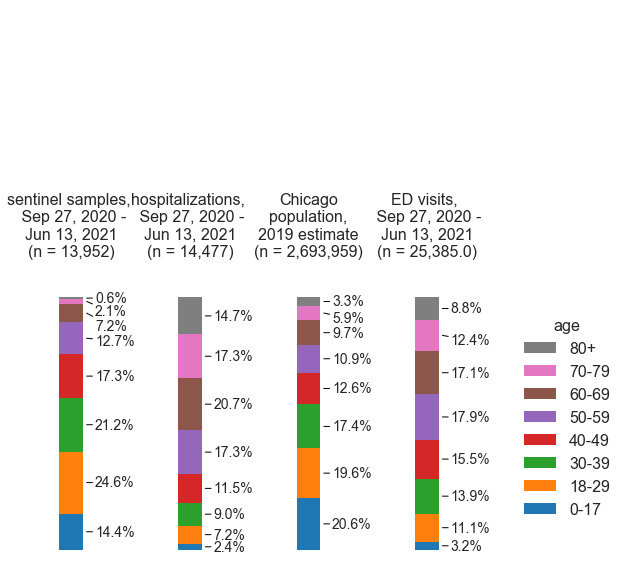

In [688]:
race_palette = ['#f68621', '#1ba18b', '#923059', '#8972b3', '#a8a8a8', '#ffffff']
age_palette = sns.color_palette()

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8.5, 10))
width = 0.2
axes[0].set_xlim([-0.5,3.5])        
axes[0].text(s='sentinel samples, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(race_breakdown['sentinel'].sum()) + ')', 
             x=0, y=0.3, va='top', ha='center', fontsize=16)
axes[0].text(s='hospitalizations, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(race_breakdown['hospitalizations'].sum()) + ')', 
             x=1, y=0.3, va='top', ha='center', fontsize=16)
axes[0].text(s='Chicago\npopulation,\n2019 estimate\n(n = ' + '{:,}'.format(race_breakdown['population'].sum()) + ')', 
             x=2, y=0.3, va='top', ha='center', fontsize=16)
axes[0].text(s='ED visits, \n Sep 27, 2020 -\nJun 13, 2021\n(n = ' + '{:,}'.format(age_breakdown['ed'].sum()) + ')', 
             x=3, y=0.3, va='top', ha='center', fontsize=16)

y1 = age_breakdown.loc['80+'].values/age_breakdown.sum().values
y2 = age_breakdown.loc['70-79'].values/age_breakdown.sum().values
y3 = age_breakdown.loc['60-69'].values/age_breakdown.sum().values
y4 = age_breakdown.loc['50-59'].values/age_breakdown.sum().values
y5 = age_breakdown.loc['40-49'].values/age_breakdown.sum().values
y6 = age_breakdown.loc['30-39'].values/age_breakdown.sum().values
y7 = age_breakdown.loc['18-29'].values/age_breakdown.sum().values
y8 = age_breakdown.loc['0-17'].values/age_breakdown.sum().values
y9 = age_breakdown.loc['Unknown'].values/age_breakdown.sum().values
#axes[1].bar(x=[0, 1, 2], 
#            bottom=0, height=y9, 
#            color='w', 
#            width=width, hatch='////', edgecolor='k', linewidth=0, 
#            label='Unknown')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9, height=y8, 
            color=age_palette[0], 
            width=width, linewidth=0, 
            label='0-17')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8, height=y7, 
            color=age_palette[1], 
            width=width, linewidth=0, 
            label='18-29')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8+y7, height=y6, 
            color=age_palette[2], 
            width=width, linewidth=0, 
            label='30-39')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8+y7+y6, height=y5, 
            color=age_palette[3], 
            width=width, linewidth=0, 
            label='40-49')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8+y7+y6+y5, height=y4, 
            color=age_palette[4], 
            width=width, linewidth=0, 
            label='50-59')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8+y7+y6+y5+y4, height=y3, 
            color=age_palette[5], 
            width=width, linewidth=0, 
            label='60-69')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8+y7+y6+y5+y4+y3, height=y2, 
            color=age_palette[6], 
            width=width, linewidth=0, 
            label='70-79')
axes[1].bar(x=[0, 1, 2, 3], 
            bottom=y9+y8+y7+y6+y5+y4+y3+y2, height=y1, 
            color=age_palette[7], 
            width=width, linewidth=0, 
            label='80+')
#u_bars.set_hatch('/')
axes[0].axis('off')
axes[1].axis('off')
axes[1].set_xlim([-0.5,3.5])
handles, labels = axes[1].get_legend_handles_labels()
leg2 = axes[1].legend(handles[::-1], 
                      labels[::-1], 
                      title='age', 
                      loc='center left', 
                      fontsize=16, 
                      frameon=False, bbox_to_anchor=(1.05,0.5))
plt.setp(leg2.get_title(), fontsize=16)

sentinel = age_breakdown['sentinel'].values/age_breakdown['sentinel'].sum()
y_adjust_sentinel = [0,0,0,0,0,-0.01,-0.05,-0.04,0]
hosp = age_breakdown['hospitalizations'].values/age_breakdown['hospitalizations'].sum()
y_adjust_hosp = [0,0,0,0,0,0,0,0,0]
pop = age_breakdown['population'].values/age_breakdown['population'].sum()
y_adjust_pop = [0,0,0,0,0,0,0,-0.02,0]
ed = age_breakdown['ed'].values/age_breakdown['ed'].sum()
y_adjust_ed = [0,0,0,0,0,0,0,-0.02,0]

for ele in [8,7,6,5,4,3,2,1]:
    sentinel_height = 0 + sentinel[0:ele].sum() + sentinel[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*sentinel[ele]), 
                     xy=(0+width/2+0.03, sentinel_height), 
                     xytext=(0+width/2+0.10, sentinel_height+y_adjust_sentinel[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    hosp_height = 0 + hosp[0:ele].sum() + hosp[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*hosp[ele]), 
                     xy=(1+width/2+0.03, hosp_height), 
                     xytext=(1+width/2+0.10, hosp_height+y_adjust_hosp[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    pop_height = 0 + pop[0:ele].sum() + pop[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*pop[ele]), 
                     xy=(2+width/2+0.03, pop_height), 
                     xytext=(2+width/2+0.10, pop_height+y_adjust_pop[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
    ed_height = 0 + ed[0:ele].sum() + ed[ele]/2
    axes[1].annotate(s="{:.1f}%".format(100*ed[ele]), 
                     xy=(3+width/2+0.03, ed_height), 
                     xytext=(3+width/2+0.10, ed_height+y_adjust_ed[ele]), va='center', ha='left',
                     arrowprops={'lw':1, 'arrowstyle':'-', 'color':'k', 'shrinkA':0, 'shrinkB':0},
                     fontsize=14)
        
plt.subplots_adjust(wspace=0, hspace=0.05)
fig.savefig('fig_2_' + today_str + '_with_ED.png', dpi=200, bbox_inches='tight')
fig.savefig('fig_2_' + today_str + '_with_ED.pdf', bbox_inches='tight')

# sentinel positivity rate by race/age

In [689]:
start_date = pd.to_datetime('09-27-2020')
end_date = pd.to_datetime('06-13-2021')
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
idph_slice = idph[idph_chicago_site &
                  chi_idph & 
                  (idph['test_date'] >= start_date) & 
                  (idph['test_date'] <= end_date)]
curative_slice = curative[(curative['collection_time'] >= start_date) & 
                          (curative['collection_time'] <= end_date)]

In [690]:
print('Total specimens collected: ' + str(len(curative_slice) + len(idph_slice)))

print('With date of symptom onset: ' + str(len(idph_slice.dropna(subset=['days'])) + len(curative_slice.dropna(subset=['days']))))

Total specimens collected: 324872
With date of symptom onset: 25908


In [691]:
races = ['White, Non-Latinx', 'Other, Non-Latinx', 'Asian, Non-Latinx', 'Black, Non-Latinx', 'Other, Non-Latinx', 'Unknown']
race_array = idph[['race_white',
                   'race_american_indian_alaskan', 
                   'race_asian', 
                   'race_black_african_american', 
                   'race_hawaiian_pacific_islander',
                   'race_unknown']].values == 'Yes'
clean_race_list = []
for row in race_array:
    if np.sum(row) == 1:
        clean_race_list.append(races[np.where(row)[0][0]])
    elif np.sum(row) == 0:
        clean_race_list.append('Unknown')
    elif np.sum(row) > 1:
        clean_race_list.append('Other, Non-Latinx')
        
eth_array = idph['ethnicity'].values

race_cdph_list = []
for race, eth in zip(clean_race_list, eth_array):
    if eth == 'Hispanic or Latino':
        race_cdph_list.append('Latinx')
    elif eth == 'Non Hispanic or Latino':
        race_cdph_list.append(race)
    else:
        race_cdph_list.append('Unknown')

In [692]:
idph['cdph_race'] = race_cdph_list

In [693]:
start_date = pd.to_datetime('09-27-2020')
end_date = pd.to_datetime('06-13-2021')
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
idph_slice = idph[ss_cond & idph_chicago_site &
                  idph['chicago'] & 
                  chi_idph & 
                  (idph['test_date'] >= start_date) & 
                  (idph['test_date'] <= end_date)]
curative_slice = curative[curative['chicago'] &
                          (curative['collection_time'] >= start_date) & 
                          (curative['collection_time'] <= end_date) &
                          (curative['days'] >= 0) & 
                          (curative['days'] <= 4)]

sentinel_race_breakdown = idph_slice['cdph_race'].value_counts() + curative_slice['cdph_race'].value_counts()
sentinel_race_breakdown = sentinel_race_breakdown.rename({'Latinx':'Hispanic/Latino',
                                'Asian, Non-Latinx':'Asian, Non-Hispanic',
                                'Black, Non-Latinx':'Black, Non-Hispanic',
                                'White, Non-Latinx':'White, Non-Hispanic', 
                                'Other, Non-Latinx':'Other, Non-Hispanic', 
                                'Unknown':'Unknown'})

In [694]:
pos_cond_curative = curative_slice['test_result'] == 'POSITIVE'
curative_slice['positive'] = pos_cond_curative
pos_cond_idph = (idph_slice['result'] == 'DETECTED') | \
(idph_slice['result'] == 'POSITIVE')  | \
(idph_slice['result'] == 'Detected')
idph_slice['positive'] = pos_cond_idph

C:\Users\richa\AppData\Local\Temp\ipykernel_3592\1576145149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curative_slice['positive'] = pos_cond_curative
C:\Users\richa\AppData\Local\Temp\ipykernel_3592\1576145149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idph_slice['positive'] = pos_cond_idph


In [695]:
idx = pd.date_range('9-24-2020', '06-13-2021')
ss_df = pd.concat([idph_slice[['date_symptoms_start', 'positive', 'cdph_race']].rename(columns={'date_symptoms_start':'date'}),
           curative_slice[['patient_symptom_date', 'positive', 'cdph_race']].rename(columns={'patient_symptom_date':'date'})])
ss_df['date'] = pd.to_datetime(ss_df['date'], utc=True)
#ss_df = ss_df.set_index('date')

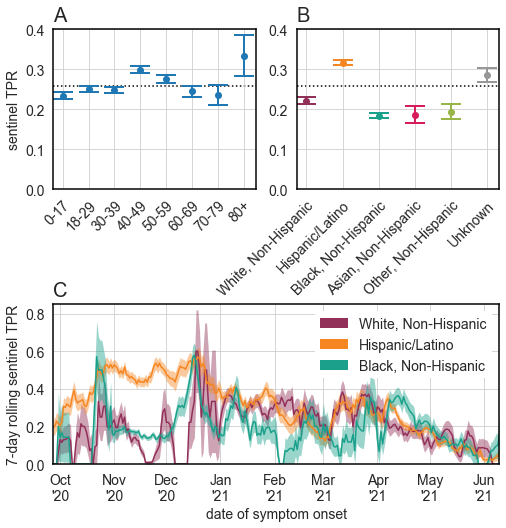

In [697]:
fig = plt.figure(constrained_layout=False, figsize=(8,8))
gs = fig.add_gridspec(3, 2, height_ratios=[1.5,0.6,1.5])
axes = []

axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[0,1]))
axes.append(fig.add_subplot(gs[2,0:2]))

pos_array = []
tot_array = []

idx = pd.date_range('9-24-2020', '06-13-2021')
ss_df = pd.concat([idph_slice[['date_symptoms_start', 'positive', 'age_group']].rename(columns={'date_symptoms_start':'date'}),
           curative_slice[['patient_symptom_date', 'positive', 'age_group']].rename(columns={'patient_symptom_date':'date'})])
ss_df['date'] = pd.to_datetime(ss_df['date'], utc=True)
#ss_df = ss_df.set_index('date')

ages = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
for age_grp, position in zip(ages, np.arange(len(ages))):

    ss_df_slice = ss_df[(ss_df['age_group'] == age_grp) & (ss_df['positive'] == True)]
    pos = ss_df_slice.groupby(['date']).count()['positive']
    pos = pos.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

    ss_df_slice = ss_df[(ss_df['age_group'] == age_grp)]
    all_test = ss_df_slice.groupby(['date']).count()['positive']
    all_test = all_test.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)
    
    p = np.sum(pos)/np.sum(all_test)
    
    pos_array.append(np.sum(pos))
    tot_array.append(np.sum(all_test))
    
    axes[0].scatter(x=position, y=p, linewidth=0, color=sns.color_palette()[0], s=50)
    axes[0].errorbar(x=position, y=p, yerr=np.sqrt(p*(1-p)/np.sum(all_test)),  
             markersize=10, 
             linewidth=2, capsize=10, markeredgewidth=2,
             color=sns.color_palette()[0])
    
axes[0].set_xticks(np.arange(len(ages)))
axes[0].tick_params('both', length=20, width=2, which='major', color='k')
axes[0].set_xticklabels(labels=ages, rotation=45, rotation_mode='anchor', ha='right')
    
idx = pd.date_range('9-24-2020', '06-13-2021')
ss_df = pd.concat([idph_slice[['date_symptoms_start', 'positive', 'cdph_race']].rename(columns={'date_symptoms_start':'date'}),
           curative_slice[['patient_symptom_date', 'positive', 'cdph_race']].rename(columns={'patient_symptom_date':'date'})])
ss_df['date'] = pd.to_datetime(ss_df['date'], utc=True)
#ss_df = ss_df.set_index('date')
    
for race_str, color_str, position in zip(['White, Non-Latinx', 'Latinx', 'Black, Non-Latinx', 
                                'Asian, Non-Latinx', 'Other, Non-Latinx', 'Unknown'], 
                               ['#923059', '#f68621', '#1ba18b', '#d61c5b', '#99b547', '#979796'],
                              np.arange(0,6)):

    ss_df_slice = ss_df[(ss_df['cdph_race'] == race_str) & (ss_df['positive'] == True)]
    pos = ss_df_slice.groupby(['date']).count()['positive']
    pos = pos.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)

    ss_df_slice = ss_df[(ss_df['cdph_race'] == race_str)]
    all_test = ss_df_slice.groupby(['date']).count()['positive']
    all_test = all_test.reindex(pd.to_datetime(idx, utc=True), fill_value=0.0)
    
    p = np.sum(pos)/np.sum(all_test)
    
    pos_array.append(np.sum(pos))
    tot_array.append(np.sum(all_test))
    
    axes[1].scatter(x=position, y=p, linewidth=0, color=color_str, s=50)
    axes[1].errorbar(x=position, y=p, yerr=np.sqrt(p*(1-p)/np.sum(all_test)),  
             markersize=10, 
             linewidth=2, capsize=10, markeredgewidth=2,
             color=color_str)
    
    if np.sum(all_test) > 1000:

        pos = pos.rolling(window=7, center=True).sum()
        all_test = all_test.rolling(window=7, center=True).sum()
        p = pos/all_test
        se = np.sqrt(p*(1-p)/all_test)

        axes[2].plot(p, color=color_str)
        axes[2].fill_between(x=p.index, y1=p-se, y2=p+se, color=color_str, alpha=0.25, linewidth=0)
        axes[2].fill_between(x=p.index, y1=p-se, y2=p+se, color=color_str, alpha=0.25, linewidth=0)

axes[0].set_ylim([0,0.4])
axes[1].set_ylim([0,0.4])
axes[1].set_xticks(np.arange(0,6))
axes[1].tick_params('both', length=20, width=2, which='major', color='k')
axes[1].set_xticklabels(labels=['White, Non-Hispanic', 
                    'Hispanic/Latino', 
                    'Black, Non-Hispanic', 
                    'Asian, Non-Hispanic', 
                    'Other, Non-Hispanic', 
                    'Unknown'], rotation=45, rotation_mode='anchor', ha='right')

axes[2].set_xlim([pd.to_datetime('9-27-2020'), 
                      pd.to_datetime('6-10-2021')])
axes[2].set_ylim([0,0.85])
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%b\n'%y"))
axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    #axes[1].set_yticks([0.5,1.00,1.5])
    
axes[0].axhline(np.sum(ss_df['positive'] == True)/len(ss_df), zorder=0, linestyle='dotted', color='k')
axes[1].axhline(np.sum(ss_df['positive'] == True)/len(ss_df), zorder=0, linestyle='dotted', color='k')
#axes[0].grid(axis='y')
#axes[1].grid(axis='y')
    
for ax in axes:
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(labelsize=14, axis='both', direction='out', width=1.5, length=5, color='k')
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
i_up = 0 
'''
for i in np.arange(1,len(pos_array)):
    counts = np.array([pos_array[0], pos_array[i]])
    nobs = np.array([tot_array[0], tot_array[i]])
    stat, pval = proportions_ztest(counts, nobs)
    #ax.text(s='p = ' + "{:.1e}".format(pval), x=i, y=p_s[i]+std_s[i]+0.01, va='bottom', ha='center', fontsize=14, c='k')
    print(pval)
    #ax.plot([0,i], [0.1*i+0.1, 0.1*i+0.1], color='k')
    y = 0.1*i_up+0.4+0.01
    if pval > 0.05:
        sig_str = 'n.s.'
    else:
        if pval > 0.01:
            sig_str = '*'
        elif pval > 0.0001:
            sig_str = '**'
        else:
            sig_str = '***'
        axes[1].plot([0,i], [y, y], color='k')
        axes[1].vlines(x=[0,i], ymin=y-0.03, ymax=y)
        axes[1].text(s="p = {:.1e}".format(pval), x=(i)/2, y=y+0.01, va='bottom', ha='left', fontsize=14, c='k')
        i_up += 1
'''
axes[0].text(s='A', x=0, y=1.05, transform=axes[0].transAxes, fontsize=20)
axes[1].text(s='B', x=0, y=1.05, transform=axes[1].transAxes, fontsize=20)
axes[2].text(s='C', x=0, y=1.05, transform=axes[2].transAxes, fontsize=20)
axes[0].set_ylabel('sentinel TPR', fontsize=14)
axes[2].set_ylabel('7-day rolling sentinel TPR', fontsize=14)
axes[2].set_xlabel('date of symptom onset', fontsize=14)

axes[2].fill_between(x=[], y1=[], y2=[], color='#923059', alpha=1, linewidth=0, label='White, Non-Hispanic')
axes[2].fill_between(x=[], y1=[], y2=[], color='#f68621', alpha=1, linewidth=0, label='Hispanic/Latino')
axes[2].fill_between(x=[], y1=[], y2=[], color='#1ba18b', alpha=1, linewidth=0, label='Black, Non-Hispanic')
leg = axes[2].legend(fontsize=14, edgecolor=None, framealpha=1)
leg.get_frame().set_linewidth(0.0)

fig.savefig('positivity_by_race_age_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('positivity_by_race_age_' + today_str + '.pdf', bbox_inches='tight')

# Lead time stuff

In [51]:
extent = 30
window_start_date = pd.to_datetime(dt.datetime(day=27, month=9, year=2020), utc=True)
window_end_date = pd.to_datetime(dt.datetime(day=13, month=6, year=2021), utc=True)
df = pd.merge(cli_cdph_series, covid_ed_series, left_index=True, right_index=True)
df = df[(df.index >= window_start_date) & (df.index <= window_end_date)]
df.columns = ['1','2']

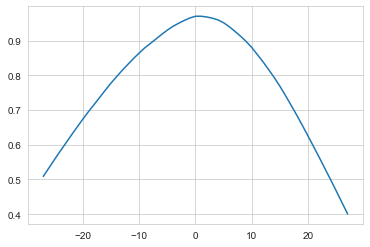

In [139]:
rho_array = []
lead_time_array = np.arange(-(extent-3), extent-3+1)
for lead_time in lead_time_array:
    rho, p = scipy.stats.spearmanr(df['1'].rolling(window=7, center=True).mean()[extent:-extent].values, 
                          df['2'].rolling(window=7, center=True).mean()[extent-lead_time:-extent-lead_time].values)
    rho_array.append(rho)
plt.plot(lead_time_array, rho_array)

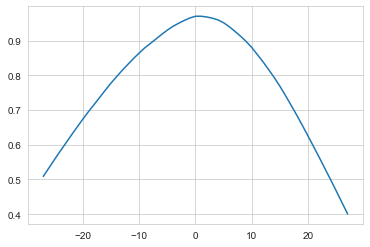

In [141]:
plt.plot(lead_time_array, rho_array)

In [142]:
array1 = df['1'].rolling(window=7, center=True).mean()[extent:-extent].values
array2 = df['2'].rolling(window=7, center=True).mean()[extent:-extent].values

In [144]:
result_df = pd.DataFrame({'lead_time':[], 'rho':[], 'p':[], 'ci_low':[], 'ci_high':[]})
lead_time_array = np.arange(-(extent-3), extent-3+1)
for lead_time in lead_time_array:
    array1 = df['1'].rolling(window=7, center=True).mean()[extent:-extent].values
    array2 = df['1'].rolling(window=7, center=True).mean()[extent-lead_time:-extent-lead_time].values
    rho, p, ci_low, ci_high = spearman_ci(array1, array2, alpha=0.05, n_boot=100)
    result_df = result_df.append(pd.DataFrame({'lead_time':[lead_time],'rho':[rho], 'p':[p], 'ci_low':[ci_low], 'ci_high':[ci_high]}))
result_df = result_df.reset_index(drop=True)

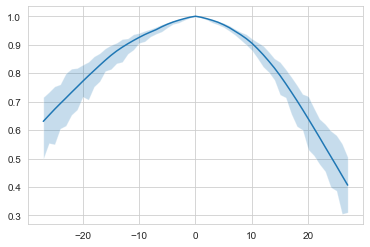

In [145]:
plt.plot(result_df['lead_time'], result_df['rho'])
plt.fill_between(result_df['lead_time'], result_df['ci_low'], result_df['ci_high'], alpha=0.25)

In [54]:
%%time
r_storage = []
combo_adjust_storage = []
for cap in [1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
        curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)
    combo_adjust_storage.append(combo_adjust)
    np.random.seed(2022)
    r_combo_adjust = covid19.r_covid(combo_adjust[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_storage.append(r_combo_adjust.copy())

CPU times: total: 2.94 s
Wall time: 2.93 s


In [62]:
def spearman_ci(array1, array2, alpha=0.05, n_boot=100):
    percentiles = np.array([alpha/2, 1-(alpha/2)])
    nom_val, nom_p = scipy.stats.spearmanr(array1, array2)
    rho_array = []
    for ii in range(n_boot):
        indeces = np.random.choice(range(len(array1)), replace=True, size=len(array1))
        rho_array.append(scipy.stats.spearmanr(array1[indeces], array2[indeces])[0])
    return nom_val, nom_p, np.percentile(rho_array, 100*percentiles[0]), np.percentile(rho_array, 100*percentiles[1])

In [68]:
test_array = [combo_adjust_storage[0], combo_ss['positive'], #unadjusted
              tpr, case_series, cli_ed_series, covid_ed_series, cli_series, cli_cdph_series]

In [69]:
comparison_array_labels = ['SC, no adjust', 
                           'SS',
                           'SC/SS', 
                           'cases',
                           'CLI ED', 
                           'COVID ED', 
                           'CLI admits', 
                           'COVID admits']

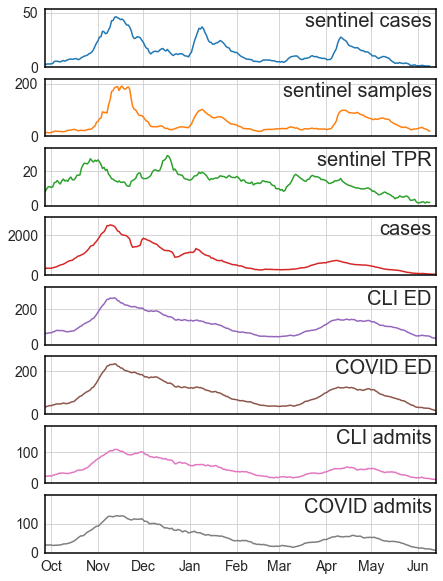

In [112]:
test_array = [combo_adjust_storage[0], combo_ss['positive'], #unadjusted
              tpr, case_series, cli_ed_series, covid_ed_series, cli_series, cli_cdph_series]
r_comparison_array_labels = ['sentinel cases', 'sentinel samples', 
                             'sentinel TPR', 'cases', 'CLI ED', 'COVID ED','CLI admits', 'COVID admits']
palette = sns.color_palette()

fig = plt.figure(figsize=(7,10))
gs = fig.add_gridspec(len(test_array), 1)

window_start_date = pd.to_datetime(dt.datetime(day=27, month=9, year=2020), utc=True)
window_end_date = pd.to_datetime(dt.datetime(day=13, month=6, year=2021), utc=True)

axes = []
for trace, ii in zip(test_array, range(len(test_array))):
    ax = fig.add_subplot(gs[ii,0])
    axes.append(ax)
    series = trace.rolling(window=7, center=True).mean()
    ax.plot(series, linewidth=1.5, color=palette[ii])
    ax.set_xlim([window_start_date, window_end_date])
    
    ax.text(s=r_comparison_array_labels[ii], x=0.99, y=0.95, fontsize=20,
            transform=ax.transAxes, ha='right', va='top')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_ylim([0,series.max()*1.15])
    
    ax.tick_params(axis='both', labelsize=14)
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')

for ax in axes[0:len(test_array)-1]:
    ax.set_xticklabels([])

for ax in axes:
    ax.tick_params(axis='both', labelsize=14)
    
fig.savefig('all_timeseries_plotted_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('all_timeseries_plotted_' + today_str + '.pdf', bbox_inches='tight')

In [113]:
%%time
extent = 30
n_boot = 1000
np.random.seed(1000)
window_start_date = pd.to_datetime(dt.datetime(day=27, month=9, year=2020), utc=True)
window_end_date = pd.to_datetime(dt.datetime(day=13, month=6, year=2021), utc=True)
lead_time_array = np.arange(-(extent-3), extent-3+1)

test_array = [combo_adjust_storage[0], combo_ss['positive'], #unadjusted
              tpr, case_series, cli_ed_series, covid_ed_series, cli_series, cli_cdph_series]
result_df_array = []
for j in range(len(test_array)):
    for k in range(j+1):
        df = pd.merge(test_array[k], test_array[j], left_index=True, right_index=True)
        df = df[(df.index >= window_start_date) & (df.index <= window_end_date)]
        df.columns = ['1','2']
        result_df = pd.DataFrame({'lead_time':[], 'rho':[], 'p':[], 'ci_low':[], 'ci_high':[]})
        for lead_time in lead_time_array:
            array1 = df['1'].rolling(window=7, center=True).mean()[extent:-extent].values
            array2 = df['2'].rolling(window=7, center=True).mean()[extent+lead_time:-extent+lead_time].values
            rho, p, ci_low, ci_high = spearman_ci(array1, array2, alpha=0.05, n_boot=n_boot)
            result_df = result_df.append(pd.DataFrame({'lead_time':[lead_time],'rho':[rho], 'p':[p], 'ci_low':[ci_low], 'ci_high':[ci_high]}))
        result_df = result_df.reset_index(drop=True)
        result_df_array.append(result_df)

CPU times: total: 12min 20s
Wall time: 12min 25s


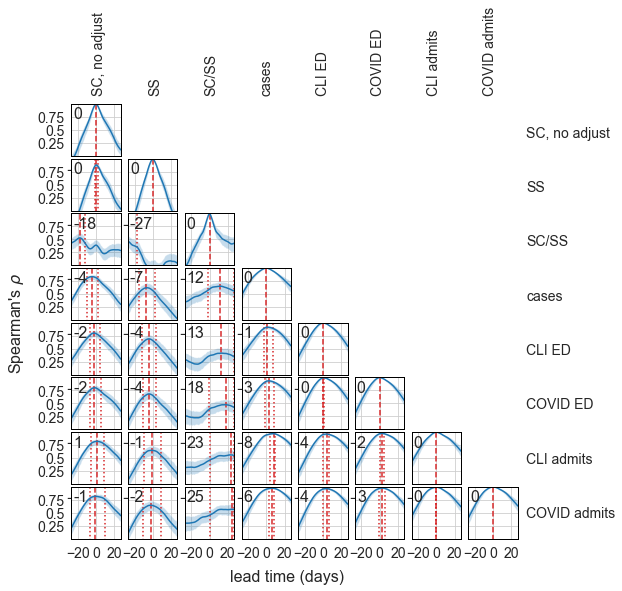

In [114]:
fig = plt.figure(constrained_layout=False, figsize=(8,8))
gs = fig.add_gridspec(len(test_array), len(test_array))
gs.update(wspace=0.15, hspace=0.05)
ii = 0
axes = []
comparison_array_labels = ['SC, no adjust', 
                           'SS',
                           'SC/SS', 
                           'cases',
                           'CLI ED', 
                           'COVID ED', 
                           'CLI admits', 
                           'COVID admits']

for j in range(len(test_array)):
    for k in range(j+1):
        ax = fig.add_subplot(gs[j,k])
        axes.append(ax)
        result_df = result_df_array[ii]
        result_df_short = result_df[result_df['ci_high'] >= result_df['rho'].max()]
        ax.plot(result_df['lead_time'], result_df['rho'])
        ax.fill_between(result_df['lead_time'], result_df['ci_low'], result_df['ci_high'], alpha=0.25)
        ax.vlines(result_df['lead_time'].values[np.argmax(result_df['rho'])], 
                  ymin=-1.1, 
                  ymax=1.1, 
                  color=sns.color_palette()[3], linestyle='dashed')
        ax.text(s=str(int(result_df['lead_time'].values[np.argmax(result_df['rho'])])), 
                x=-25, y=0.95, fontsize=16,
                ha='left', 
                va='top')
        if j != k:
            ax.vlines([result_df_short['lead_time'].min(), result_df_short['lead_time'].max()], 
                      ymin=-1.1, 
                      ymax=1.1, 
                      color=sns.color_palette()[3], linestyle='dotted')
            #ax.text(s='[' + str(int(result_df_short['lead_time'].min())) + ' - ' + 
            #        str(int(result_df_short['lead_time'].max())) + ']',
            #        x=-26, y=0.8, fontsize=10,
            #        ha='left', 
            #        va='top')
        ii += 1
        if k == 0:
            ax.set_yticks([0.25,0.5,0.75])
            ax.set_yticklabels([0.25,0.5,0.75])
        else:
            ax.set_yticks([0.25,0.5,0.75])
            ax.set_yticklabels([])
            
for ax, index in zip(axes, range(len(axes))):
    ax.set_ylim([0.0,1.0])
    ax.set_xlim([-extent+3,extent-3])
    #ax.set_yticklabels([])
    ax.set_xticks([-20,0,20])
    ax.tick_params(axis='both', labelsize=14)
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1)
        ax.spines[pos].set_color('k')
        
fig.text(s=r"Spearman's $\rho$", fontsize=16, x=0.03, y=0.5, rotation=90, va='center', ha='center')
fig.text(s='lead time (days)', fontsize=16, x=0.5, y=0.06, rotation=0, va='center', ha='center')

#for label, index in zip(comparison_array_labels, range(len(comparison_array_labels))):
#    fig.text(s=label, fontsize=16, 
#             x=0.80*(index+1)/len(comparison_array_labels), y=1.0, 
#             rotation=45, va='bottom', ha='left', weight='bold')
#    fig.text(s=label, fontsize=16, 
#             y=1-0.80*(index+1)/len(comparison_array_labels), x=1.0, 
#             rotation=0, va='center', ha='left', weight='bold')
    
ax = fig.add_subplot(gs[:,:])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(comparison_array_labels, fontsize=16)
ax.set_yticks([7,6,5,4,3,2,1,0])
ax.set_yticklabels(comparison_array_labels, fontsize=16)
ax.set_xlim([-0.5,7.5])
ax.set_ylim([-0.5,7.5])
# make xaxis invisibel
#ax.yaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(ax.spines.values(), visible=False)
# remove ticks and labels for the left axis
#ax.tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
ax.patch.set_visible(False)
ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.grid(False)
ax.tick_params(axis='both', labelsize=14, pad=5, rotation=0)
ax.tick_params(axis='x', labelsize=14, pad=5, rotation=90)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
fig.savefig('fig_3_lead_time_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('fig_3_lead_time_' + today_str + '.pdf', bbox_inches='tight')

In [153]:
result_df['lead_time'].values[np.argmax(result_df['rho'])]

0.0

In [154]:
result_df = result_df_array[1]
result_df_short = result_df[result_df['ci_high'] >= result_df['rho'].max()]

In [155]:
ii = 0
axes = []
comparison_array_labels = ['SC, no adjust', 
                           'SC/SS',
                           'cases',
                           'CLI ED', 
                           'COVID ED',                           
                           'CLI admits', 
                           'COVID admits']

for j in range(len(test_array)):
    for k in range(j+1):
        result_df_array[ii]['front_compare'] = comparison_array_labels[j]
        result_df_array[ii]['back_compare'] = comparison_array_labels[k]
        ii += 1

In [156]:
full_result_df = pd.concat(result_df_array)

In [157]:
full_result_df.to_csv('./data/cca_results_' + today_str + '.csv', index=False)

In [158]:
idph['symptomatic_per_cdc'].value_counts()

No         290853
Yes         88239
Unknown      5115
Name: symptomatic_per_cdc, dtype: int64

# Sensitivity analysis on day cutoff (3 days vs 4 days vs 5 days)

Showing distribution of times from symptom onset to test:

In [116]:
window_start_date = dt.datetime(day=27, month=9, year=2020)
window_end_date = dt.datetime(day=13, month=6, year=2021)

idph_slice = idph[idph['chicago'] & chi_idph & idph_chicago_site & 
                  (idph['test_date'] <= window_end_date) & (idph['test_date'] >= window_start_date)].sort_values('test_time')
idph_slice = idph_slice.dropna(subset=['days'])
    
curative_slice = curative[curative['chicago'] & 
                          (curative['collection_time'] <= window_end_date) & 
                          (curative['collection_time'] >= window_start_date)]
curative_slice = curative_slice.dropna(subset=['days'])

In [117]:
cutoff = 20
np.sum((curative_slice['days'] <= cutoff) & (curative_slice['days'] >= 0)) + \
np.sum((idph_slice['days'] <= cutoff) & (idph_slice['days'] >= 0))

18602

In [118]:
np.sum(len(idph_slice) + len(curative_slice))

21406

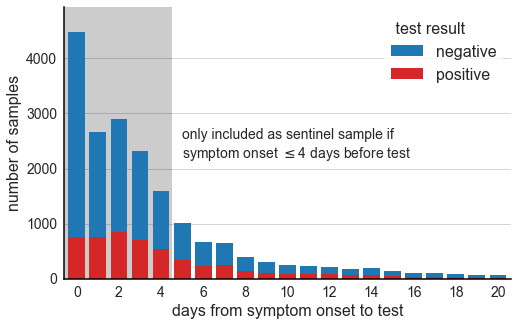

In [119]:
fig = plt.figure(figsize=(8,5))
bins = np.arange(-0.4,25.5,1)
y_all, x, patch = plt.hist(list(idph_slice['days'].values) + list(curative_slice['days'].values), 
                       bins=bins, width=0.8, linewidth=0, label='negative')

y_pos, x, patch = plt.hist(list(idph_slice[idph_slice['positive'] == True]['days'].values) + 
                       list(curative_slice[curative_slice['positive'] == True]['days'].values), 
                       bins=bins, width=0.8, linewidth=0, label='positive', color=sns.color_palette()[3])

ax = plt.gca()
ax.fill_between(x=[-10,4.5], y1=0, y2=10000, color='k', alpha=0.2, linewidth=0)
ax.set_xticks(np.arange(0,25,2))
ax.set_xlim([-0.6,20.6])
ax.set_ylim([0, np.max(y_all)*1.1])
ax.set_ylabel('number of samples', fontsize=16)
ax.set_xlabel('days from symptom onset to test', fontsize=16)
ax.tick_params(labelsize=14)
ax.text(s='only included as sentinel sample if\n' + r'symptom onset $\leq$4 days before test', x=5, y=2200, fontsize=14)
leg = ax.legend(frameon=True, fontsize=16, loc='upper right', framealpha=0.75, title=' test result')
leg.get_frame().set_linewidth(0)
leg._legend_box.align = "left"
leg.get_title().set_fontsize(16)

for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(1.5)
    ax.spines[pos].set_color('k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x')

fig.savefig('supp_fig_4_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_4_' + today_str + '.pdf', bbox_inches='tight')

In [120]:
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[(idph['days'] >= 0) & (idph['days'] <= 4) & idph['chicago'] & chi_idph & idph_chicago_site & 
                      (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                              (curative['days'] >= 0) & (curative['days'] <= 4)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx

combo_sc_4 = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss_4 = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)

print(len(all_cases))
print(all_cases['positive'].sum())

13952
3607


In [121]:
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[(idph['days'] >= 0) & (idph['days'] <= 3) & idph['chicago'] & chi_idph & idph_chicago_site & 
                      (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                              (curative['days'] >= 0) & (curative['days'] <= 3)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx

combo_sc_3 = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss_3 = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)

print(len(all_cases))
print(all_cases['positive'].sum())

12351
3070


In [122]:
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[(idph['days'] >= 0) & (idph['days'] <= 5) & idph['chicago'] & chi_idph & idph_chicago_site & 
                      (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                              (curative['days'] >= 0) & (curative['days'] <= 5)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx

combo_sc_5 = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss_5 = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)

print(len(all_cases))
print(all_cases['positive'].sum())

14959
3949


In [123]:
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[(idph['days'] >= 0) & (idph['days'] <= 6) & idph['chicago'] & chi_idph & idph_chicago_site & 
                      (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                              (curative['days'] >= 0) & (curative['days'] <= 6)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx

combo_sc_6 = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss_6 = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)

print(len(all_cases))
print(all_cases['positive'].sum())

15624
4180


In [124]:
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[(idph['days'] >= 0) & (idph['days'] <= 7) & idph['chicago'] & chi_idph & idph_chicago_site & 
                      (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                              (curative['days'] >= 0) & (curative['days'] <= 7)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx

combo_sc_7 = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss_7 = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)

print(len(all_cases))
print(all_cases['positive'].sum())

16271
4427


<Figure size 576x360 with 0 Axes>

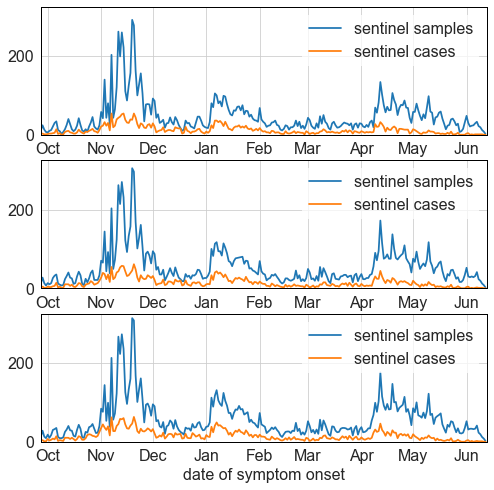

In [125]:
fig = plt.figure(figsize=(8,5))

palette = sns.color_palette()
fig = plt.figure(constrained_layout=False, figsize=(8,8))
gs = fig.add_gridspec(3, 1, height_ratios=[1.5,1.5,1.5])
axes = []

ax = fig.add_subplot(gs[0,0])
axes.append(ax)
window_start_date = dt.datetime(day=27, month=9, year=2020)
window_end_date = dt.datetime(day=13, month=6, year=2021)
ax.plot(combo_ss_3, color=sns.color_palette()[0], label='sentinel samples', linewidth=1.75)
ax.plot(combo_sc_3, color=sns.color_palette()[1], label='sentinel cases', linewidth=1.75)
#ax.plot(combo_adjust, color=sns.color_palette()[3], label='adjusted sentinel cases\n(cap = 40)')
#plt.plot(idph_adjust, color=sns.color_palette()[5], label='IDPH adjusted\nsentinel cases\n(cap = 10)')

ax.set_xlabel('date of symptom onset', fontsize=16)
#ax.set_yticks(np.arange(0,16,5))
#ax.set_ylim([0,20])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_locator(mdates.MonthLocator()) #ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis='both', labelsize=16) #loc = WeekdayLocator(byweekday=MO, interval=2)
#ax.grid(False, axis='y')
for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(1)
    ax.spines[pos].set_color('k')
ax.set_xlim([window_start_date, window_end_date])
ax.set_ylim([0,325])
leg = ax.legend(frameon=True, fontsize=16, loc='upper right', framealpha=0.75)
leg.get_frame().set_linewidth(0)

ax = fig.add_subplot(gs[1,0])
axes.append(ax)
window_start_date = dt.datetime(day=27, month=9, year=2020)
window_end_date = dt.datetime(day=13, month=6, year=2021)
ax.plot(combo_ss_4, color=sns.color_palette()[0], label='sentinel samples', linewidth=1.75)
ax.plot(combo_sc_4, color=sns.color_palette()[1], label='sentinel cases', linewidth=1.75)
#ax.plot(combo_adjust, color=sns.color_palette()[3], label='adjusted sentinel cases\n(cap = 40)')
#plt.plot(idph_adjust, color=sns.color_palette()[5], label='IDPH adjusted\nsentinel cases\n(cap = 10)')

ax.set_xlabel('date of symptom onset', fontsize=16)
#ax.set_yticks(np.arange(0,16,5))
#ax.set_ylim([0,20])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_locator(mdates.MonthLocator()) #ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis='both', labelsize=16) #loc = WeekdayLocator(byweekday=MO, interval=2)
#ax.grid(False, axis='y')
for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(1)
    ax.spines[pos].set_color('k')
ax.set_xlim([window_start_date, window_end_date])
ax.set_ylim([0,325])
leg = ax.legend(frameon=True, fontsize=16, loc='upper right', framealpha=0.75)
leg.get_frame().set_linewidth(0)

ax = fig.add_subplot(gs[2,0])
axes.append(ax)
window_start_date = dt.datetime(day=27, month=9, year=2020)
window_end_date = dt.datetime(day=13, month=6, year=2021)
ax.plot(combo_ss_5, color=sns.color_palette()[0], label='sentinel samples', linewidth=1.75)
ax.plot(combo_sc_5, color=sns.color_palette()[1], label='sentinel cases', linewidth=1.75)
#ax.plot(combo_adjust, color=sns.color_palette()[3], label='adjusted sentinel cases\n(cap = 40)')
#plt.plot(idph_adjust, color=sns.color_palette()[5], label='IDPH adjusted\nsentinel cases\n(cap = 10)')

ax.set_xlabel('date of symptom onset', fontsize=16)
#ax.set_yticks(np.arange(0,16,5))
#ax.set_ylim([0,20])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_locator(mdates.MonthLocator()) #ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis='both', labelsize=16) #loc = WeekdayLocator(byweekday=MO, interval=2)
#ax.grid(False, axis='y')
for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(1)
    ax.spines[pos].set_color('k')
ax.set_xlim([window_start_date, window_end_date])
ax.set_ylim([0,325])
leg = ax.legend(frameon=True, fontsize=16, loc='upper right', framealpha=0.75)
leg.get_frame().set_linewidth(0)
#fig.savefig('fig_1_panel_b_c_' + today_str + '.png', dpi=200, bbox_inches='tight')
#fig.savefig('fig_1_panel_b_c_' + today_str + '.pdf', bbox_inches='tight')

In [126]:
np.random.seed(2022)
r_3 = covid19.r_covid(combo_sc_3, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_4 = covid19.r_covid(combo_sc_4, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_5 = covid19.r_covid(combo_sc_5, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_6 = covid19.r_covid(combo_sc_6, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_7 = covid19.r_covid(combo_sc_7, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)

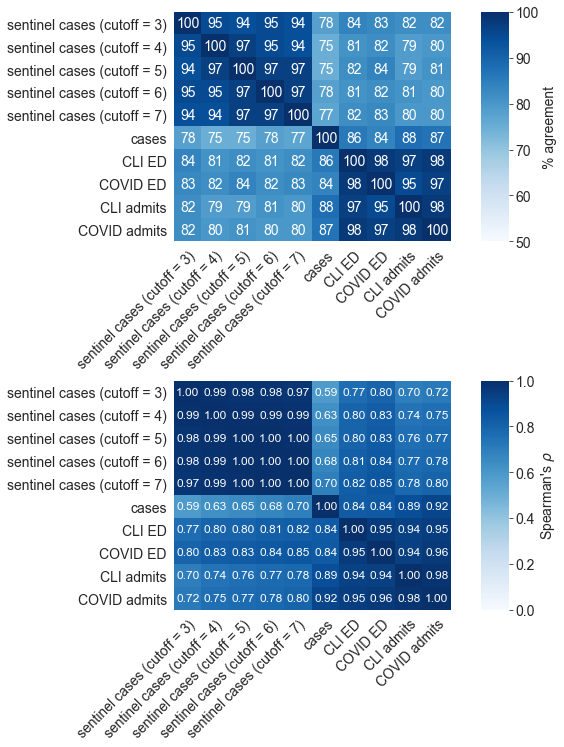

In [133]:
fig = plt.figure(constrained_layout=False, figsize=(6,11))
gs = fig.add_gridspec(3, 2, width_ratios=[1,0.1], height_ratios=[1,0.3,1])

r_comparison_array = [r_3, r_4, r_5, r_6, r_7, r_case, r_cli, r_cli_cdph, r_cli_ed, r_covid_ed]
r_comparison_array_labels = ['sentinel cases (cutoff = 3)', 
                             'sentinel cases (cutoff = 4)', 
                             'sentinel cases (cutoff = 5)', 
                             'sentinel cases (cutoff = 6)', 
                             'sentinel cases (cutoff = 7)',
                             'cases', 'CLI ED', 'COVID ED','CLI admits', 'COVID admits']

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[0,0])
cbax = fig.add_subplot(gs[0,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = spearmanr(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

ax = fig.add_subplot(gs[2,0])
cbax = fig.add_subplot(gs[2,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((similarity_matrix), vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':12})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)

fig.savefig('supp_fig_5_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_5_' + today_str + '.pdf', bbox_inches='tight')

# Subsampling (previous normalization approach used by CDPH)

In [441]:
%%time
np.random.seed(1000)
r_storage = []
combo_adjust_storage = []
for cap in [10,20,40,1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
        curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)
    combo_adjust_storage.append(combo_adjust)
    np.random.seed(2022)
    r_combo_adjust = covid19.r_covid(combo_adjust[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_storage.append(r_combo_adjust.copy())
    
tpr = pd.DataFrame(index = combo_sc.index, data={'cases':combo_ss['positive'].mean()*combo_sc.values.astype(int)/combo_ss['positive'].values})['cases']
np.random.seed(2022)
r_combo_adjust = covid19.r_covid(tpr[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

CPU times: total: 13 s
Wall time: 13 s


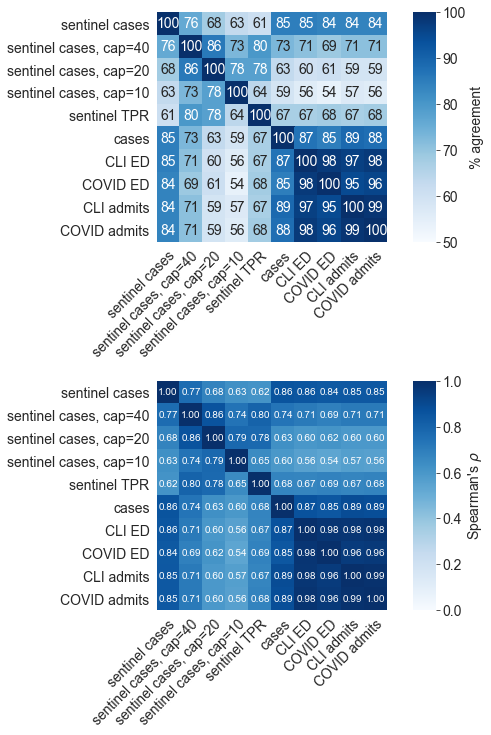

In [442]:
fig = plt.figure(constrained_layout=False, figsize=(5,11))
gs = fig.add_gridspec(3, 2, width_ratios=[1,0.1], height_ratios=[1,0.3,1])

r_comparison_array = [r_storage[3], r_storage[2], r_storage[1], r_storage[0], r_storage[4], r_case, r_cli, r_cli_cdph, r_cli_ed, r_covid_ed]
r_comparison_array_labels = ['sentinel cases', 'sentinel cases, cap=40', 'sentinel cases, cap=20', 'sentinel cases, cap=10', 'sentinel TPR', 
                             'cases', 'CLI ED', 'COVID ED','CLI admits', 'COVID admits']

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

# agreement
ax = fig.add_subplot(gs[0,0])
cbax = fig.add_subplot(gs[0,-1])
#axes.append(ax)
#axes.append(cbax)
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)

# spearman
ax = fig.add_subplot(gs[2,0])
cbax = fig.add_subplot(gs[2,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((similarity_matrix), vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':10})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)

fig.savefig('supp_fig_6_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_6_' + today_str + '.pdf', bbox_inches='tight')

# turnaround time

In [118]:
idph_slice = idph[idph_chicago_site &
                  (idph['test_date'] >= start_date) & 
                  (idph['test_date'] <= end_date)]
idph_slice['total_time_to_results'] = [x.days for x in pd.to_datetime(idph_slice['result_date'], utc=True) - pd.to_datetime(idph_slice['test_date'], utc=True)]
curative_slice = curative[(curative['collection_time'] >= start_date) & 
                          (curative['collection_time'] <= end_date)]

ss_df = pd.concat([idph_slice[['test_date', 
                               'total_time_to_results']].rename(columns={'test_date':'date'}), 
                   curative_slice[['collection_time', 
                                   'total_time_to_results']].rename(columns={'collection_time':'date'})])
                   
ss_df['date'] = pd.to_datetime(ss_df['date'], utc=True)
#ss_df['result_date'] = pd.to_datetime(ss_df['result_date'], utc=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_11044\3611638637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idph_slice['total_time_to_results'] = [x.days for x in pd.to_datetime(idph_slice['result_date'], utc=True) - pd.to_datetime(idph_slice['test_date'], utc=True)]


In [123]:
ss_df['total_time_to_results'].median()

2.0

In [125]:
ss_df['total_time_to_results'].quantile(0.975)

4.0

In [126]:
ss_df['total_time_to_results'].quantile(0.025)

1.0